# Gaussian Process Regression (GPR) - GPflow

Export this jupyter file (.ipynb) to python (.py) with:

`jupyter nbconvert --to script main_pipeline.ipynb --template=simplepython.tpl --RegexRemovePreprocessor.patterns="['# hide']"`

* `--to script`: to executable file in the written language (here: python)
* `--template=simplepython.tpl`: removes markdown and raw files
* `--RegexRemovePreprocessor.patterns="['# hide']"`: removes cells starting with `# hide`

In [188]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame as DF
import matplotlib.image as img
from ipywidgets import interact, interactive, fixed, interact_manual, Dropdown, IntSlider, widgets
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import math
import scipy
import scipy.io

# gpflow
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
from gpflow.utilities import print_summary, set_trainable, to_default_float

# gpytorch
import torch
import gpytorch

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 2)

PATH = './data'
PATH_SAVE = './graphics/GPR'

### helper functions

In [2]:
# ========== HELPER FUNCTIONS ============================

In [3]:
def set_index_to_nonnumeric_cols(data):
    if isinstance(data, dict):
        return {el : set_index_to_nonnumeric_cols(data[el]) for el in data}
    elif isinstance(data, pd.DataFrame):
        return set_index_to_nonnumeric_cols_df(data)
    
def drop_nans(data):
    if isinstance(data, dict):
        return {el : drop_nans(data[el]) for el in data}
    elif isinstance(data, pd.DataFrame):
        return data.dropna(axis=1, how='all')
    
def set_index_to_nonnumeric_cols_df(df):
    nonnumeric_columns = get_nonnumeric_columns(df)
    numeric_columns = get_numeric_columns(df)
    if nonnumeric_columns != []:
        if numeric_columns != []:
            df = df.set_index(nonnumeric_columns)
            df.index.name = '_'.join(nonnumeric_columns)
        else:
            df = df.set_index(nonnumeric_columns[0])
    else:
        df.index.name = 'hours'
    if is_multi_index(df.index):
        df = remove_multiindex_df(df, axis=0)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df.select_dtypes(include=[np.number]).columns.values)
    return numeric_columns

def get_nonnumeric_columns(df):
    nonnumeric_columns = list(df.select_dtypes(exclude=[np.number]).columns.values)
    return nonnumeric_columns

def is_multi_index(lst):
    return isinstance(lst[0], tuple)

In [4]:
# hide
        
def to_mat(L, mean, output_name='LoadData_new'):
    if L is not None: # if covariance matrix is not singular s.t. Cholesky decomposition exists

        # new output file
        out = dict()
        out['__header__'] = b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Sep 07 13:14:25 2018'
        out['__version__'] = '1.0'
        out['__globals__'] = []
        out['Lpost'] = L
        out['mu_post'] = mean

        # save to .mat file
        scipy.io.savemat(str('data/covariance_matrices/' + output_name + '.mat'), out)

        print('Successfully stored load data!!')

    else:
        print('Sorry, no output!')

In [5]:
# GPflow

In [6]:
def GPFLOW_set_params(model, kernel, parameters=[0.01, 0.1, 0.1]):
    
    if parameters:
        likelihood_variance = parameters[0]
        kernel_lengthscales = parameters[1]
        kernel_variance = parameters[2]
    
        # parameters (trainable)
        model.likelihood.variance.assign(likelihood_variance)

        if kernel.name not in ['sum', 'product']: # single kernel
            model.kernel.variance.assign(kernel_variance)
            if kernel.name not in ['linear', 'polynomial', 'constant', 'product']:
                model.kernel.lengthscales.assign(kernel_lengthscales)
        else: # multiple kernels
            for i in range(len(model.kernel.kernels)):
                model.kernel.kernels[i].variance.assign(kernel_variance)
                if model.kernel.kernels[i].name not in ['linear', 'polynomial', 'constant', 'product']:
                    model.kernel.kernels[i].lengthscales.assign(kernel_lengthscales)
                
    return model

def GPFLOW_set_trainable(model, kernel, trainable=[True, True, True]):
    
    if trainable:
        likelihood_variance = trainable[0]
        kernel_lengthscales = trainable[1]
        kernel_variance = trainable[2]
    
        # parameters (trainable)
        set_trainable(model.likelihood.variance, likelihood_variance)

        if kernel.name not in ['sum', 'product']: # single kernel
            set_trainable(model.kernel.variance, kernel_variance)
            if kernel.name not in ['linear', 'polynomial', 'constant', 'product']:
                set_trainable(model.kernel.lengthscales, kernel_lengthscales)
        else: # multiple kernels
            for i in range(len(model.kernel.kernels)):
                set_trainable(model.kernel.kernels[i].variance, kernel_variance)
                if model.kernel.kernels[i].name not in ['linear', 'polynomial', 'constant', 'product']:
                    set_trainable(model.kernel.kernels[i].lengthscales, kernel_lengthscales)
                
    return model

def GPFLOW_model(X, Y, gpflow_kernel, gpflow_meanf, params=None, trainable=None):
    m = gpflow.models.GPR(data=(X, Y), kernel=gpflow_kernel, mean_function=gpflow_meanf)
    m = GPFLOW_set_params(m, gpflow_kernel, params)
    m = GPFLOW_set_trainable(m, gpflow_kernel, trainable)
    return m

def GPFLOW_optimize(m):
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
    return opt_logs
        
def GPFLOW_predict(m, T, xx=None):
    if xx is None:
        xx = np.linspace(-0.1, 1.5, T).reshape(T, 1)
    mean, var = m.predict_f(xx)
    _, cov_full = m.predict_f(xx, full_cov=True)
    cov = cov_full.numpy()[0,:,:]
    return mean.numpy(), var, cov

def GPFLOW_sample(m, xx):
    tf.random.set_seed(1)
    samples = m.predict_f_samples(xx, 10)  # (10, 100, 1)
    return samples

def GPFLOW_plot(m, X, Y, mean, var, cov, T):    
    xx = np.linspace(-0.1, 2.1, T).reshape(T, 1)
    xx_ = np.linspace(-0.1, 1.1, T).reshape(T, 1)
    samples = GPFLOW_sample(m, xx)
    
    fig = plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2)
    plt.plot(xx_, mean, "red", lw=2)
    plt.fill_between(xx_[:, 0], mean[:, 0] - 1.96 * np.sqrt(var[:, 0]), 
                     mean[:, 0] + 1.96 * np.sqrt(var[:, 0]), color="C0", alpha=0.2)
    plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
    plt.ylim(-0.1, 1.1)
    plt.xlim(-0.1, 2.1)
    if kernel.name not in ['sum', 'product']:
        plt.title(m.kernel.name)
    else:
        plt.title([m.kernel.kernels[i].name for i in range(len(m.kernel.kernels))])
    plt.show()
    
    ax = sns.heatmap(cov)
    plt.show()
    
def GPFLOW_run(X, Y, kernel, meanf, params, trainable, T, OPT=True):
    m = GPFLOW_model(X, Y, kernel, meanf, params, trainable)
    opt_logs = GPFLOW_optimize(m) if OPT else None
    mean, var, cov = GPFLOW_predict(m, T)
    return m, mean, var, cov

In [7]:
def GPFLOW_plot_it(X, Y, xx, m, mean, var, cov, samples, w, T=150):
    fig = plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2)
    plt.fill_between(xx[:, 0], mean[:, 0] - 1.96 * np.sqrt(var[:, 0]), 
                     mean[:, 0] + 1.96 * np.sqrt(var[:, 0]), color="red", alpha=0.2)
    plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
    plt.plot(xx, mean, "red", lw=2)
    #plt.ylim(-0.1, 1.1)
    #plt.xlim(100, 200)
    plt.xlabel("hours")
    plt.ylabel("demand (MWh)")
    if kernel.name not in ['sum', 'product']:
        plt.title(m.kernel.name)
    else:
        plt.title([m.kernel.kernels[i].name for i in range(len(m.kernel.kernels))])
    plt.show()
    
    print_summary(m)

    sns.heatmap(cov)
    plt.title("Covariance matrix")
    plt.show()

    a, b = T, 12
    cov_small = cov[a:a+b, a:a+b]
    sns.heatmap(cov_small)
    plt.title("Covariance matrix excerpt")
    plt.show()
    
    sns.heatmap(cov + w*np.eye(len(cov)))
    plt.title("Covariance matrix + whitening")
    plt.show()
    
    L = scipy.linalg.cholesky(cov + w*np.eye(len(cov)), lower=True)
    sns.heatmap(L)
    plt.title("Lower Cholesky + whitening")
    plt.show()
    
    L_small = L[a:a+b, a:a+b]
    sns.heatmap(L_small)
    plt.title("Lower Cholesky excerpt + whitening")
    plt.show()

    plt.plot(mean)
    plt.title("mean demand")
    plt.xlabel("hours")
    plt.ylabel("demand")
    plt.show()
    
    mean_small = mean[a:a+b]
    plt.plot(mean_small)
    plt.title("mean small demand")
    plt.xlabel("hours")
    plt.ylabel("demand")
    plt.show()
    
def GPFLOW_plot_it_small(X, Y, xx, m, mean, var, cov, samples, w, T):
    fig = plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2)
    plt.fill_between(xx[:, 0], mean[:, 0] - 1.96 * np.sqrt(var[:, 0]), 
                     mean[:, 0] + 1.96 * np.sqrt(var[:, 0]), color="red", alpha=0.2)
    plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
    plt.plot(xx, mean, "red", lw=2)
    #plt.ylim(-0.1, 1.1)
    #plt.xlim(100, 200)
    plt.xlabel("hours")
    plt.ylabel("demand (MWh)")
    if kernel.name not in ['sum', 'product']:
        plt.title(m.kernel.name)
    else:
        plt.title([m.kernel.kernels[i].name for i in range(len(m.kernel.kernels))])
    plt.show()
    
def GPFLOW_plot_it_small2(X, Y, xx, m, mean, var, cov, samples, w, T):
    fig = plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2)
    plt.fill_between(xx[:, 0], mean[:, 0] - 1.96 * np.sqrt(var[:, 0]), 
                     mean[:, 0] + 1.96 * np.sqrt(var[:, 0]), color="red", alpha=0.2)
    plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
    plt.plot(xx, mean, "red", lw=2)
    #plt.ylim(-0.1, 1.1)
    #plt.xlim(100, 200)
    plt.xlabel("hours")
    plt.ylabel("demand (MWh)")
    if kernel.name not in ['sum', 'product']:
        plt.title(m.kernel.name)
    else:
        plt.title([m.kernel.kernels[i].name for i in range(len(m.kernel.kernels))])
    plt.show()
    
    a, b = T, 12
    mean_small = mean[a:a+b]
    plt.plot(mean_small)
    plt.title("mean small demand")
    plt.xlabel("hours")
    plt.ylabel("demand")
    plt.show()

In [8]:
def run_gpr(nodes, kernel, likelihood, T0, T, added_loads, OPT=True, PLOT=False, PLOT_LARGE=False, PLOT_MEAN=True):
    # GPR
    for i in nodes:
        node = nodes_network[i]
        print(i, node)

        # ==========================================================================
        # SAMPLING & scaling
        df = DF(hourly_demand[node]).reset_index(drop=True).loc[T0:T-1]
        df['hours'] = df.index.astype('float64')
        df.columns = ['demand', 'hours']
        hours_, demand_ = df.hours.copy(), df.demand.copy()
        
        # add loads
        if i+1 in list(added_loads.keys()):
            added_load = added_loads[i+1] # MATLAB to Python
            demand_ = np.abs(demand_ + added_load)
        offset_mean = np.mean(demand_)
        #print(demand_)
        demand_ = demand_ - offset_mean
        demand_ = demand_
        
        scaler = MinMaxScaler([0,1])
        scaler_demand = MinMaxScaler([-1,1])
        #X = np.array(np.array([DF(scaler.fit_transform(DF(df['hours'])))]).reshape((Tdiff, 1)))[0::2]
        #Y = np.array(np.array([DF(scaler_demand.fit_transform(DF(demand_)))]).reshape((Tdiff, 1)))[0::2]
        X = np.array(np.array([DF(DF(df['hours']))]).reshape((Tdiff, 1)))#[0::2]
        Y = np.array(np.array([DF(DF(demand_))]).reshape((Tdiff, 1)))#[0::2]
        #min_, scale_ = scaler_demand.min_, scaler_demand.scale_

        # ==========================================================================
        # GPR
        #kernel = gpflow.kernels.Product([gpflow.kernels.Cosine(lengthscales=[0.13], variance=0.4), gpflow.kernels.RBF(lengthscales=[0.09], variance=0.09)]) # cos len 0.16 / 0.26, RBF var 6/0.9
        #kernel = gpflow.kernels.Product([gpflow.kernels.Cosine(), gpflow.kernels.RBF()]) # cos len 0.16 / 0.26, RBF var 6/0.9
        #kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Linear(variance=0.012)])
        #kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Cosine(lengthscales=[0.33])])
        #kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Polynomial()])#(lengthscales=[0.2], variance=0.2)])
        
        meanf = gpflow.mean_functions.Constant() # None, Linear, Constant

        # run
        model = GPFLOW_model(X, Y, kernel, meanf)
        model.likelihood.variance.assign(likelihood)
        if OPT:
            opt_logs = GPFLOW_optimize(model) # optimize parameters

        # predict
        backset = 6
        lower_bd = T0
        upper_bd = T + 20 - backset
        whitening = 1e-7
        cov_scaling = 1
        n = upper_bd - lower_bd
        xx = np.linspace(lower_bd, upper_bd, n).reshape(n, 1)
        mean, var, cov = GPFLOW_predict(model, n, np.linspace(lower_bd, upper_bd, n).reshape(n, 1))
        samples = GPFLOW_sample(model, xx)

        # Cholesky decomposition
        L = None # lower triangluar matrix
        cov_ = cov*cov_scaling + whitening*np.eye(len(cov))
        a, b = Tdiff - backset, 12
        try:
            L = scipy.linalg.cholesky(cov_, lower=True)
        except:
            print("Covariance matrix is singular!")
            
        if L is not None:
            mean_small = mean[a:a+b]
            L_small = L[a:a+b,a:a+b]

            if PLOT_LARGE:
                GPFLOW_plot_it(X, Y, xx, model, mean, var, cov, samples, whitening, Tdiff)
            elif PLOT: 
                GPFLOW_plot_it_small(X, Y, xx, model, mean, var, cov, samples, whitening, Tdiff)

            # rescale and save in new file
           # mean_rescaled = ((scaler_demand.inverse_transform(mean_small)) * 0.01) # durch 100 teilen
            mean_rescaled = (mean_small + offset_mean) * 0.01
            L_rescaled = L_small
            
            #print(mean_rescaled)
            
            if PLOT_MEAN and not PLOT_LARGE:
                plt.plot(mean_rescaled)
                plt.show()

            to_mat(L_rescaled, mean_rescaled, str('LoadData_new_' + str(i)))

### Data

In [9]:
# time span
T0, T = 70, 160 # 0, 159

In [10]:
# hide

# hourly demand
sheet = ['hourly demand conties (MWh)']
excel = pd.read_excel(PATH + '/Counties Hourly Demand.xlsx', header=[0], sheet_name=sheet)
hourly_demand = set_index_to_nonnumeric_cols(drop_nans(excel))[sheet[0]] # if sheet else set_index_to_nonnumeric_cols(drop_nans(excel_file))

NameError: name 'caseTurkish' is not defined

In [13]:
hourly_demand_ = hourly_demand[caseTurkish['buses'].bus_name_dataset].reset_index(drop=True)

In [14]:
# node names (from casefile)
caseTurkish = pd.read_excel('data/caseTurkish.xlsx', header=[0], sheet_name=['buses', 'generators', 'branches'])
busses = caseTurkish['buses']
nodes_network = busses.bus_name_dataset

# hourly demand --> dict
gpr_data = {city : DF(hourly_demand[city]).reset_index(drop=True) for city in nodes_network}

### Nodes with largest load

In [15]:
# nodes with most load
n_largest = 10
d = DF(hourly_demand_.loc[T-1]).sort_values(by=[T-1]).tail(n_largest)
for i in d.index:
    print(list(caseTurkish['buses'][caseTurkish['buses'].bus_name_dataset == i].bus_number)[0])

2
45
12
11
54
7
50
6
17
41


### Add loads

In [18]:
# added_loads = "[1, 200; 2, 250; 3, 250; 4, 250; 5, 300; 6, 500; 7, 150; 17, 160; 20, 350; 25, 250; 27, 200; 28, 100; 33, 200; 34, 300; 36, 150; 37, 150; 38, 200; 39, 200; 40, 200; 41, 200; 42, 200; 43, 200; 44, 300; 45, -50; 46, 150; 47, 200; 49, 100; 50, 100; 51, 300; 52, 250; 56, 100; 57, 300; 58, 100; 59, 100; 60, 100; 61, 150]".replace('[','{').replace(']','}').replace(',',':').replace(';',',')
added_loads = {1: 200, 2: 250, 3: 250, 4: 250, 5: 300, 6: 200, 7: 150, 8: 100, 16: 200, 17: 160, 18: 100, 19: 200, 20: 350, 25: 250, 27: 200, 28: 100, 33: 200, 34: 200, 36: 150, 37: 150, 38: 200, 39: 200, 40: 200, 41: 200, 42: 200, 43: 200, 44: 300, 45: -50, 46: 150, 47: 200, 49: 100, 50: 100, 51: 300, 52: 250, 56: 100, 57: 300, 58: 100, 59: 100, 60: 100, 61: 150}

added_loads = {k : v+100 for k,v in added_loads.items()}
for k in np.array([51, 3, 20, 17, 50, 8, 7, 18, 42, 46]):
    added_loads[k] = added_loads[k] + 350 # uncertainties --> more
#added_loads

### Node groups

Different nodes need slightly different kernel configurations.

In [16]:
# groups

# all uncertainties
uncertainties = np.array([51, 3, 20, 17, 50, 8, 7, 18, 42, 46])-1 #MATLAB to Python
# special nodes
nodes_special = [26,27]
nodes_special2 = [13,14,17,20,23,27,28,32,51,57]
# rest of the nodes
nodes_rest= list(set(list(range(60))) - set(uncertainties) - set(nodes_special) - set(nodes_special2))

## GPR

#### Uncertainties

50 ESKISEHIR_Odunpazari


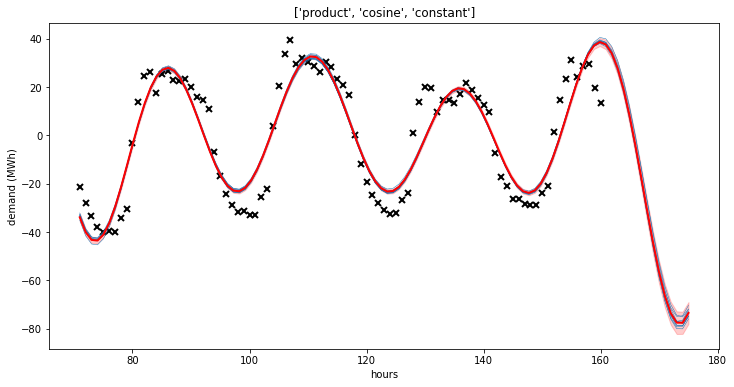

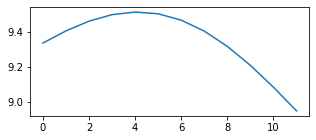

Successfully stored load data!!
2 ISTANBUL_Basaksehir


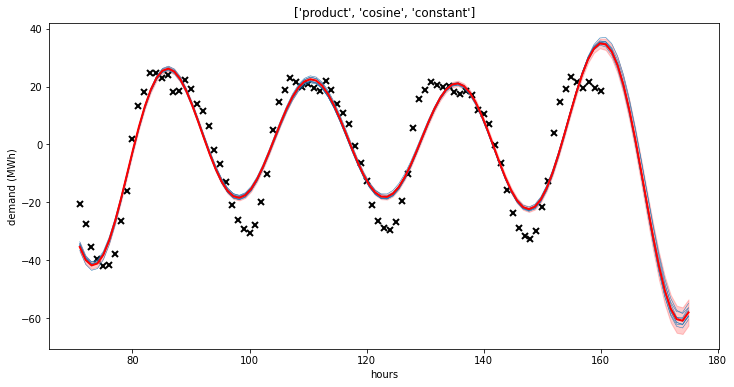

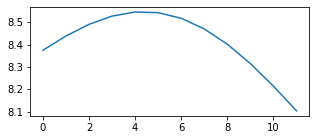

Successfully stored load data!!
19 ANKARA_Sincan


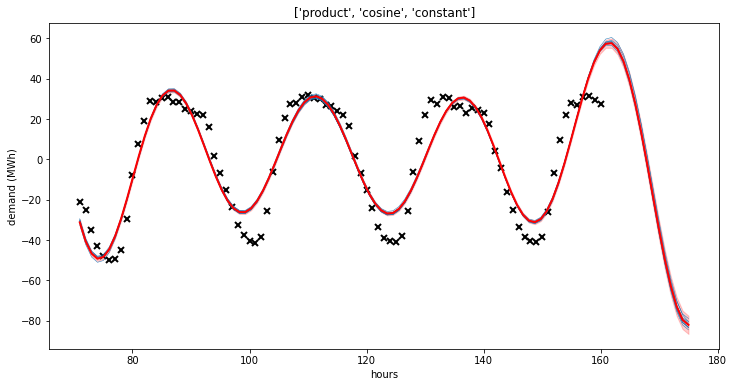

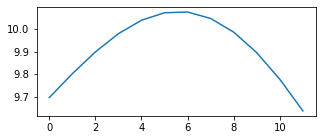

Successfully stored load data!!
16 ANKARA_Kecioren


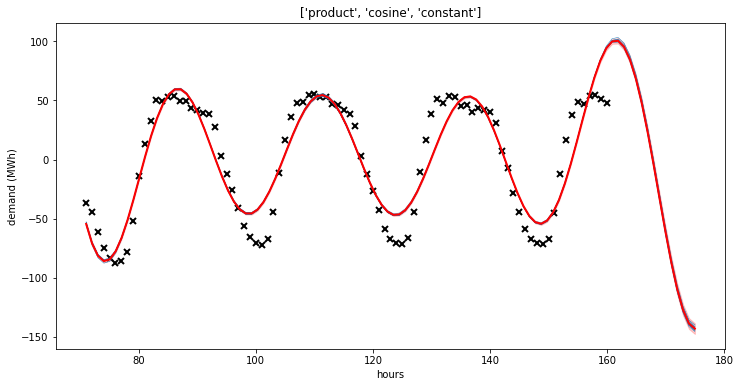

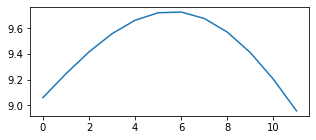

Successfully stored load data!!
49 GAZIANTEP_Sehitkamil


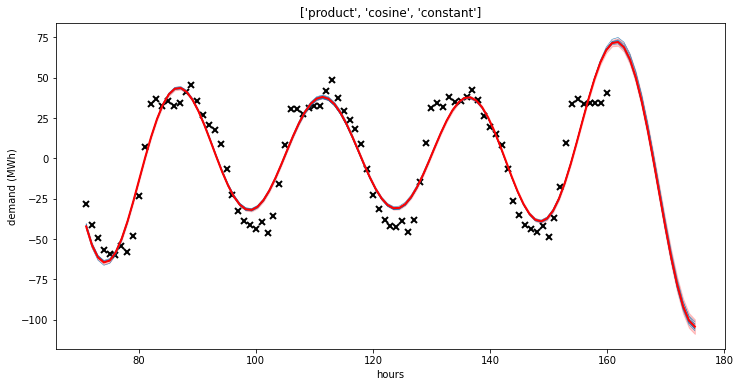

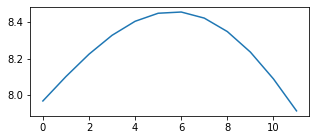

Successfully stored load data!!
7 CANAKKALE_Biga


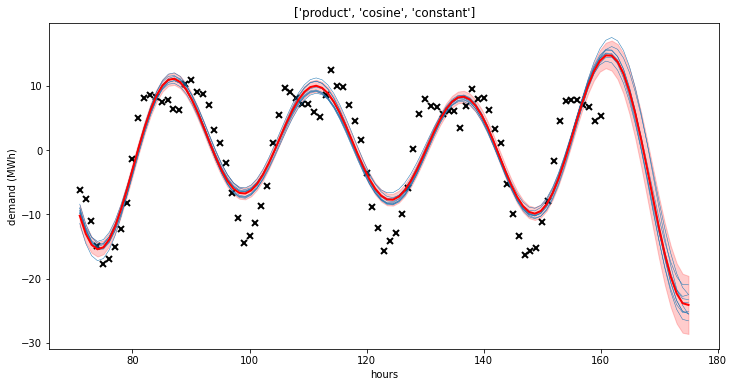

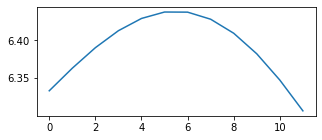

Successfully stored load data!!
6 KOCAELI_Gebze


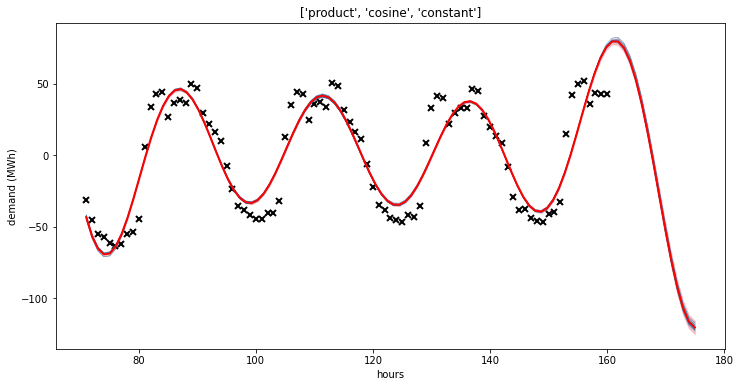

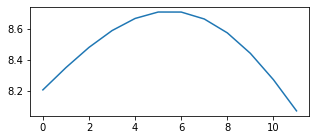

Successfully stored load data!!
17 KAYSERI_Yesilhisar


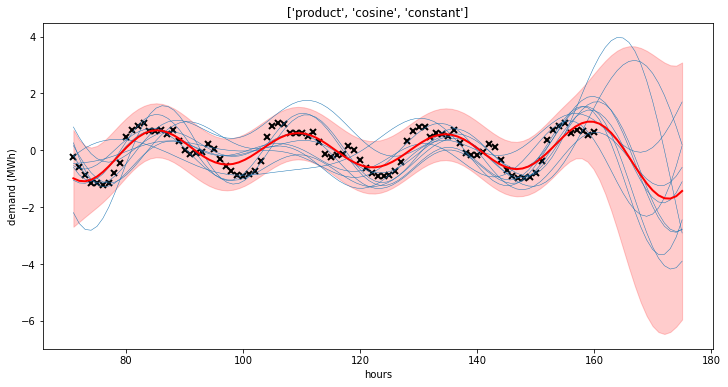

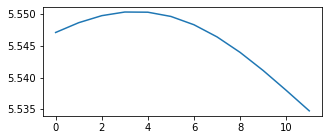

Successfully stored load data!!
41 KUTAHYA_Tavsanli


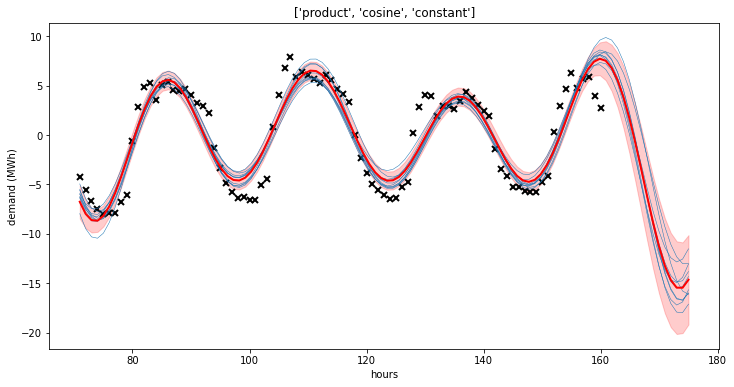

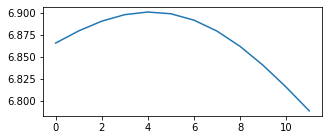

Successfully stored load data!!
45 MUGLA_Yatagan


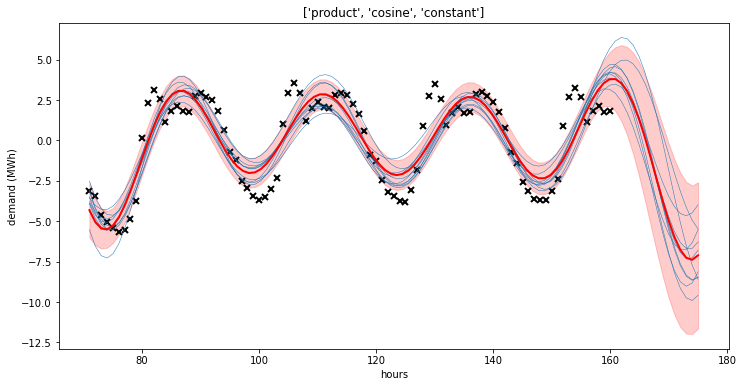

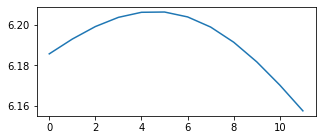

Successfully stored load data!!


In [19]:
if __name__ == '__main__':
    T0, T = 71, 161
    Tdiff = T-T0
    
    kernel = gpflow.kernels.Cosine(lengthscales=[32.3], variance=25.4)
    #kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Cosine(lengthscales=[10.9], variance=20.4)])
    kernel = gpflow.kernels.Product([kernel, gpflow.kernels.RBF(lengthscales=[105.9], variance=100.9)]) # cos len 0.16 / 0.26, RBF var 6/0.9
    #kernel = gpflow.kernels.Product([gpflow.kernels.Cosine(), gpflow.kernels.RBF()]) # cos len 0.16 / 0.26, RBF var 6/0.9
    #kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Linear(variance=1.12)])
    kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Cosine(lengthscales=[100.33], variance=10)])
    kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])
    #kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Matern12(variance=0.1, lengthscales=[5000.3])])

    # sample, increase loads, scale, fit, Cholesky, small, rescale mean
    nodes = list(range(len(nodes_network)))
    for node in nodes_special:
        nodes.remove(node)
        
    run_gpr(uncertainties, kernel, 2.5, T0, T, added_loads, OPT=False, PLOT=True, PLOT_LARGE=False, PLOT_MEAN=True)

50 ESKISEHIR_Odunpazari


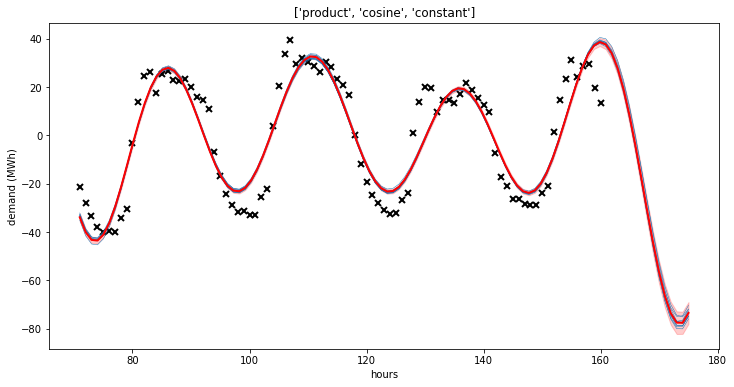

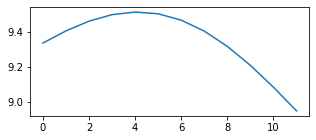

Successfully stored load data!!
2 ISTANBUL_Basaksehir


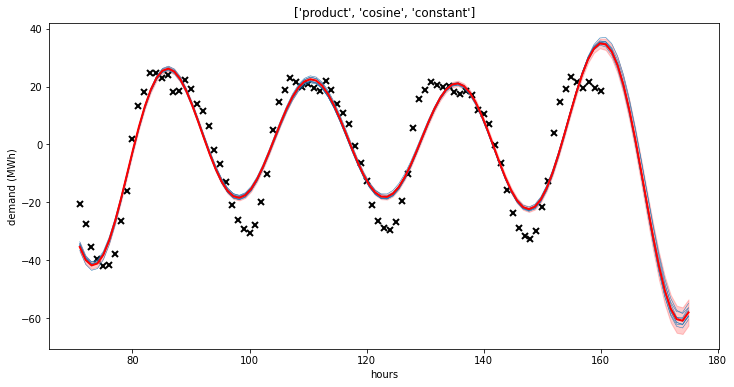

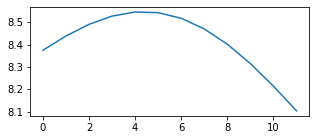

Successfully stored load data!!
19 ANKARA_Sincan


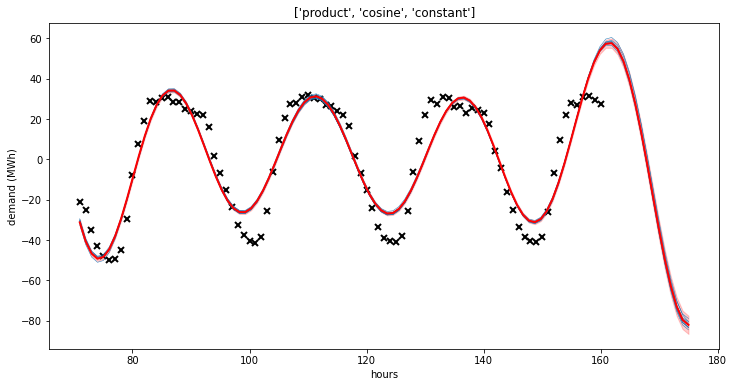

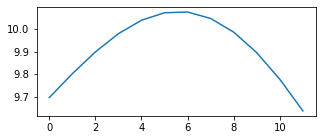

Successfully stored load data!!
16 ANKARA_Kecioren


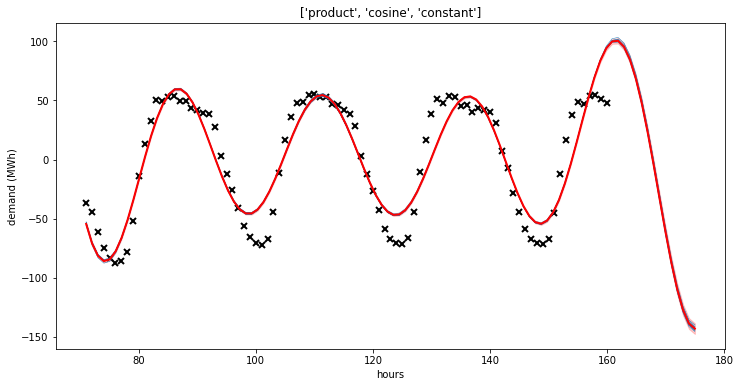

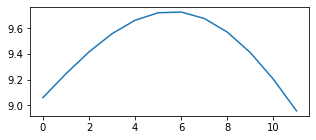

Successfully stored load data!!
49 GAZIANTEP_Sehitkamil


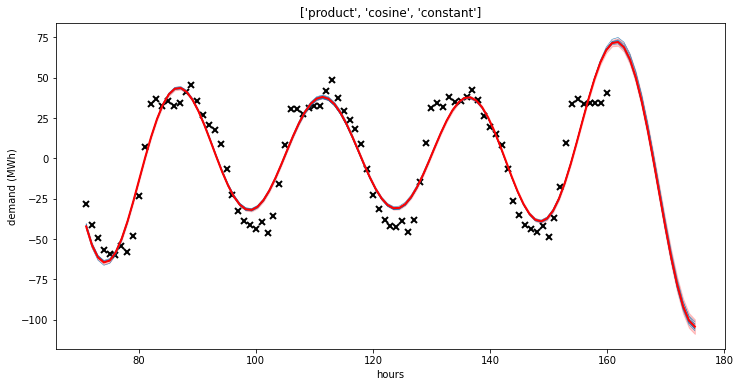

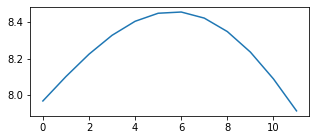

Successfully stored load data!!
7 CANAKKALE_Biga


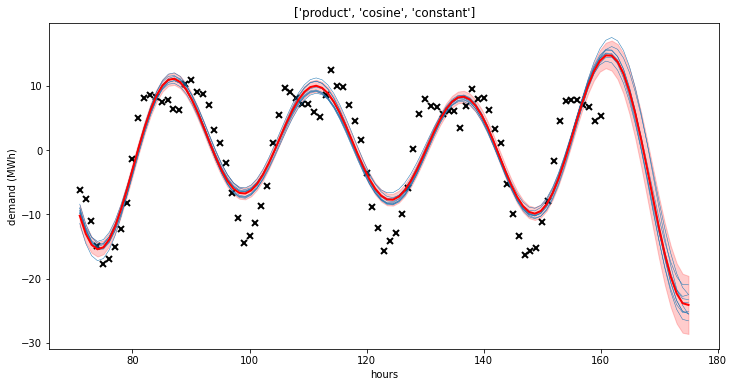

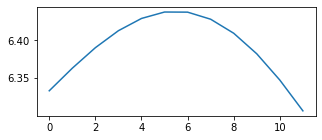

Successfully stored load data!!
6 KOCAELI_Gebze


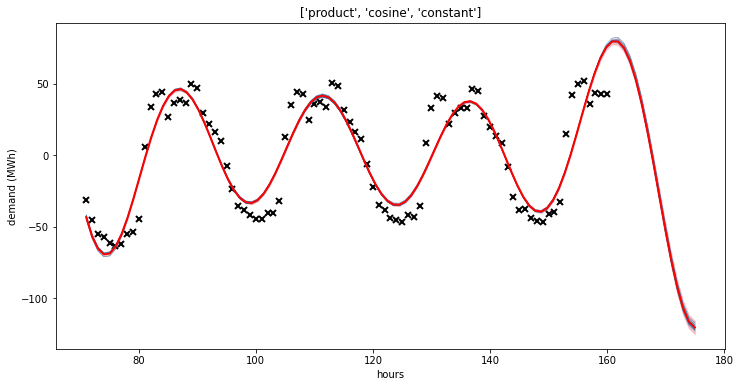

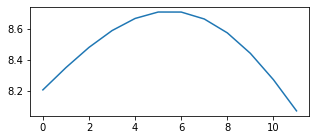

Successfully stored load data!!
17 KAYSERI_Yesilhisar


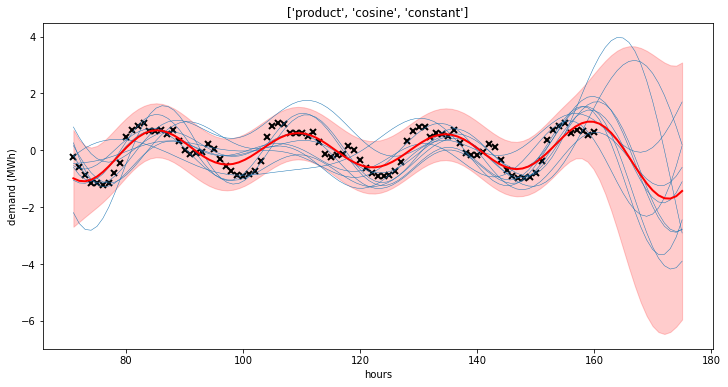

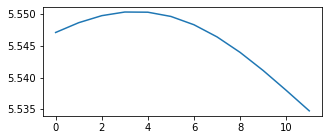

Successfully stored load data!!
41 KUTAHYA_Tavsanli


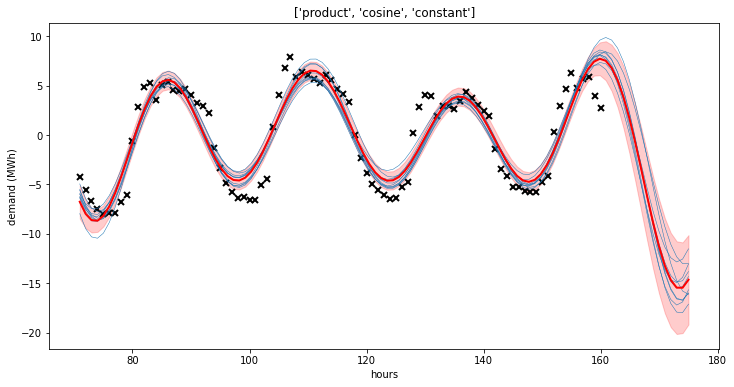

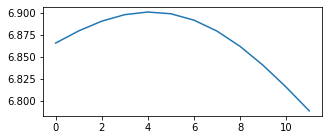

Successfully stored load data!!
45 MUGLA_Yatagan


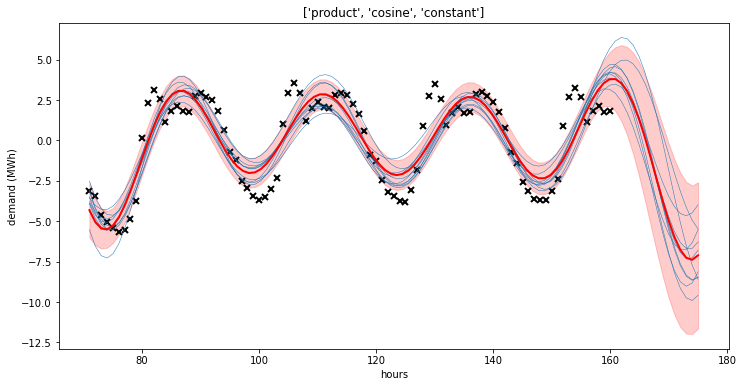

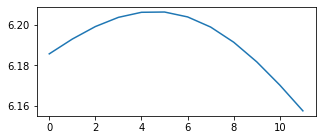

Successfully stored load data!!


In [365]:
if __name__ == '__main__':
    T0, T = 71, 161
    Tdiff = T-T0
    
    kernel = gpflow.kernels.Cosine(lengthscales=[32.3], variance=25.4)
    #kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Cosine(lengthscales=[10.9], variance=20.4)])
    kernel = gpflow.kernels.Product([kernel, gpflow.kernels.RBF(lengthscales=[105.9], variance=100.9)]) # cos len 0.16 / 0.26, RBF var 6/0.9
    #kernel = gpflow.kernels.Product([gpflow.kernels.Cosine(), gpflow.kernels.RBF()]) # cos len 0.16 / 0.26, RBF var 6/0.9
    #kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Linear(variance=1.12)])
    kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Cosine(lengthscales=[100.33], variance=10)])
    kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])
    #kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Matern12(variance=0.1, lengthscales=[5000.3])])

    # sample, increase loads, scale, fit, Cholesky, small, rescale mean
    nodes = list(range(len(nodes_network)))
    for node in nodes_special:
        nodes.remove(node)
        
    run_gpr(uncertainties, kernel, 2.5, T0, T, added_loads, OPT=False, PLOT=True, PLOT_LARGE=False, PLOT_MEAN=True)

#### Special nodes

26 ERZURUM_Yakutiye


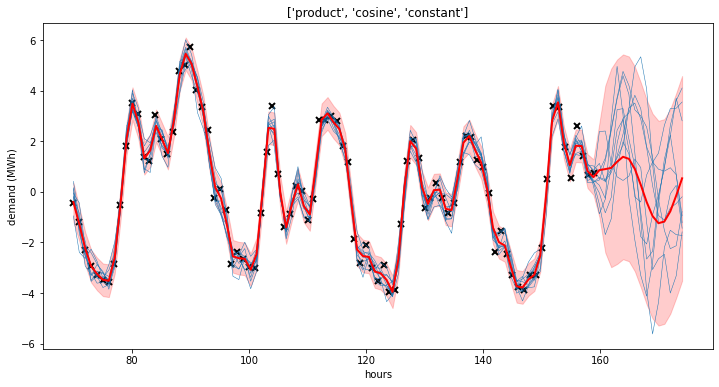

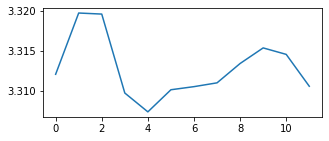

Successfully stored load data!!
27 AGRI_Merkez


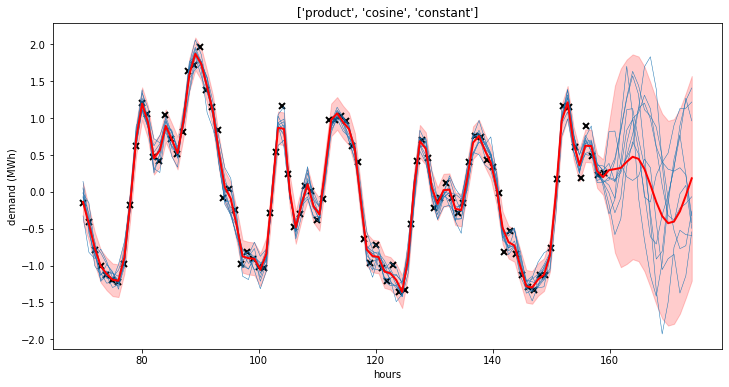

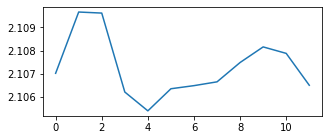

Successfully stored load data!!


In [304]:
if __name__ == '__main__':
    baseMVA = 100
        
    kernel = gpflow.kernels.Product([gpflow.kernels.Cosine(lengthscales=[10.13], variance=1.4), gpflow.kernels.RBF(lengthscales=[10.9], variance=9.9)]) # cos len 0.16 / 0.26, RBF var 6/0.9
    #kernel = gpflow.kernels.Product([gpflow.kernels.Cosine(), gpflow.kernels.RBF()]) # cos len 0.16 / 0.26, RBF var 6/0.9
    #kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Linear(variance=0.00012)])
    kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Cosine(lengthscales=[10.33])])
    #kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Polynomial()])#(lengthscales=[0.2], variance=0.2)])
    kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])
    #kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Matern52(variance=0.11, lengthscales=[200.3])])

    run_gpr(nodes_special, kernel, 1.5, T0, T, added_loads, OPT=True, PLOT=True, PLOT_LARGE=False, PLOT_MEAN=True)

13 HATAY_Erzin


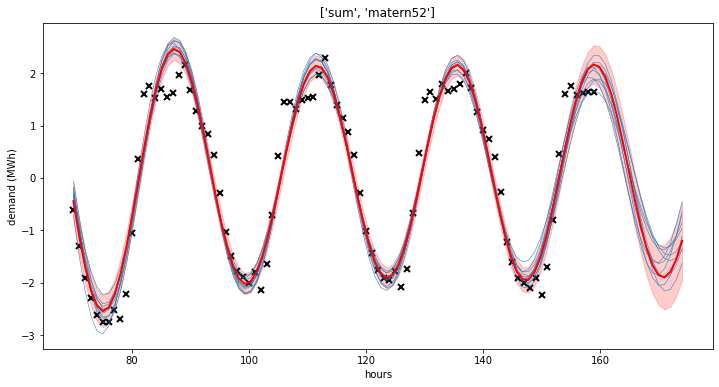

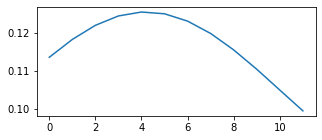

Successfully stored load data!!
14 KAHRAMANMARAS_Andirin


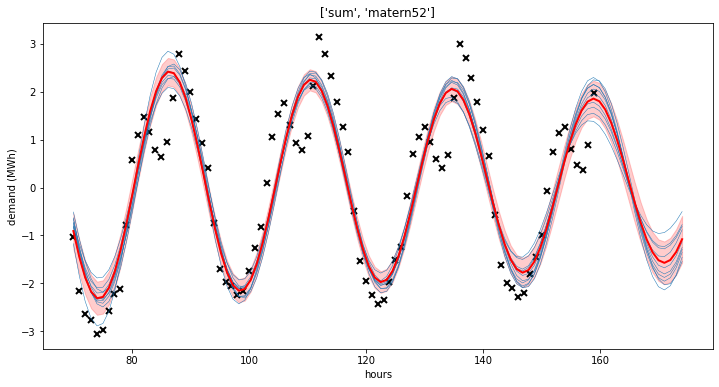

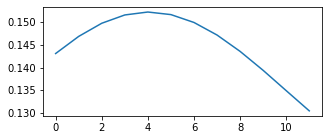

Successfully stored load data!!
17 KAYSERI_Yesilhisar


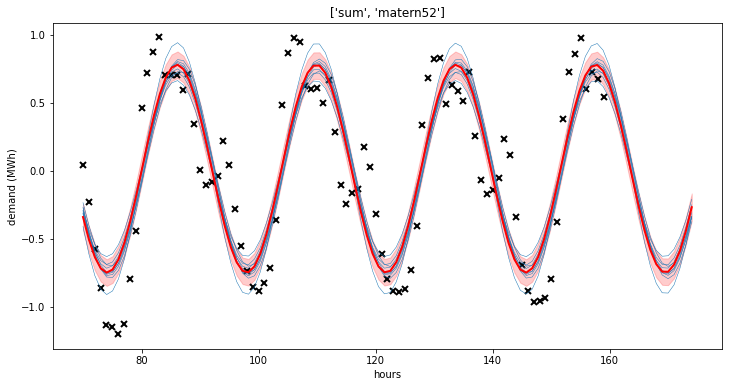

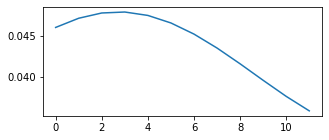

Successfully stored load data!!
20 CANKIRI_Kursunlu


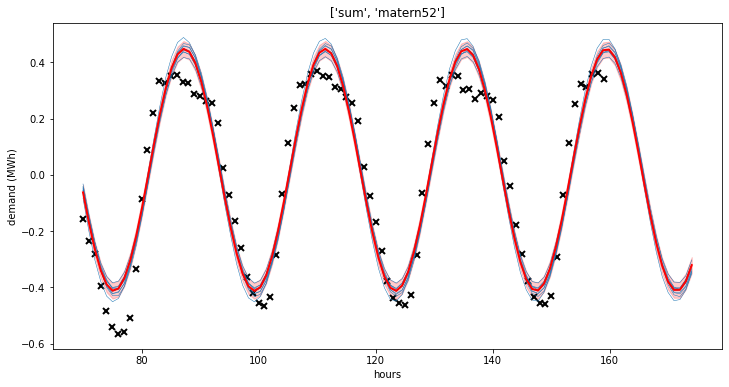

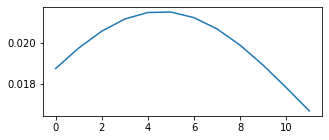

Successfully stored load data!!
23 GIRESUN_Tirebolu


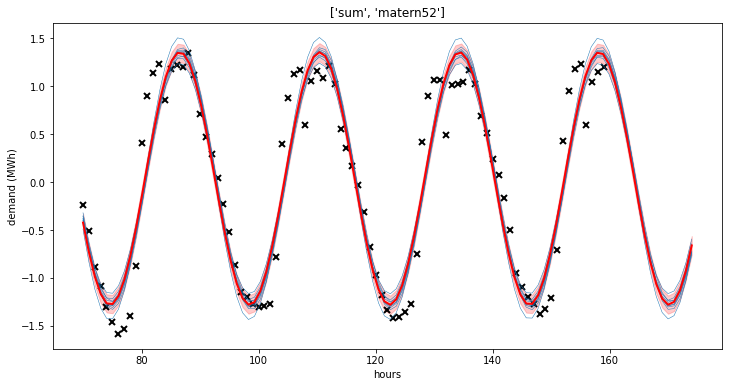

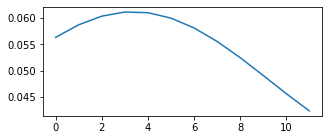

Successfully stored load data!!
27 AGRI_Merkez


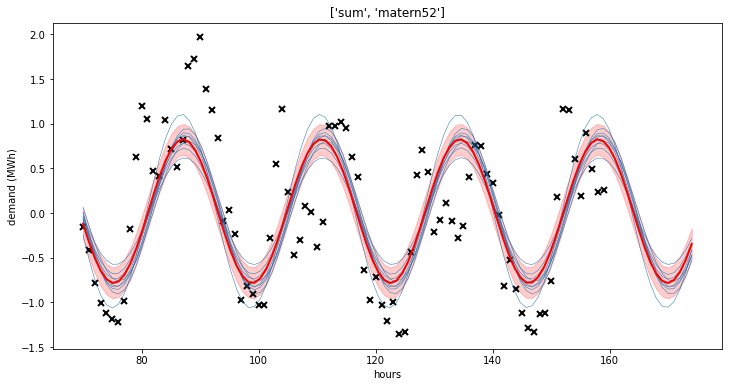

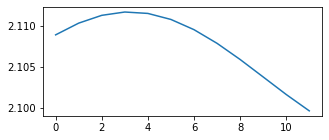

Successfully stored load data!!
28 ELAZIG_Karakocan


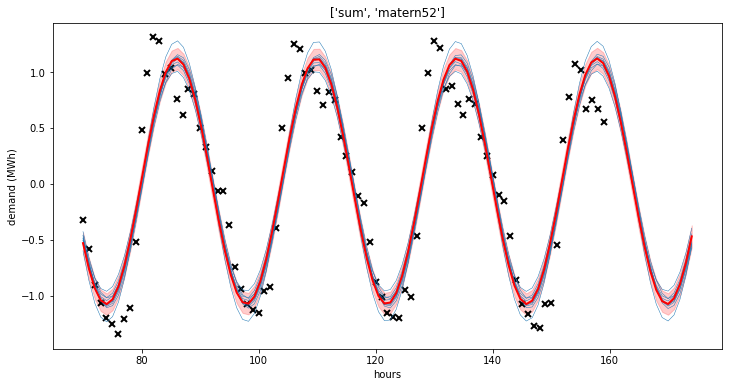

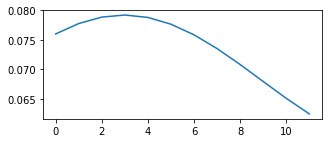

Successfully stored load data!!
32 ELAZIG_Keban


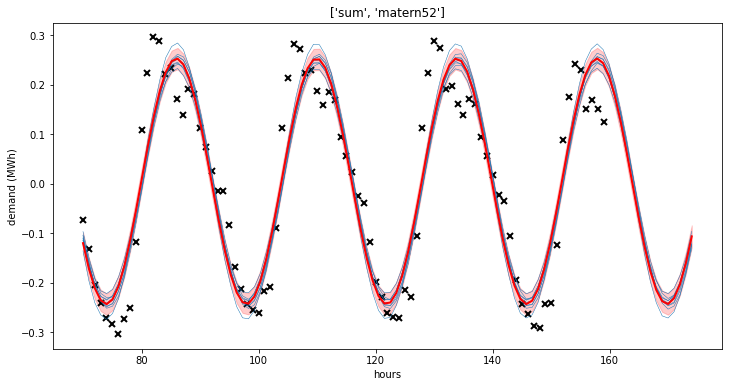

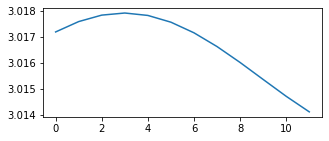

Successfully stored load data!!
51 ESKISEHIR_Alpu


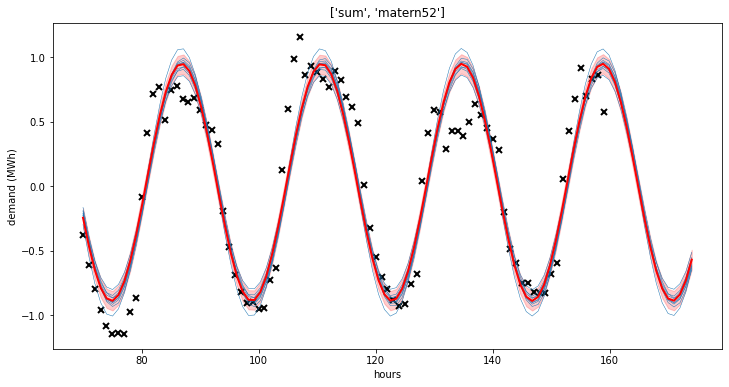

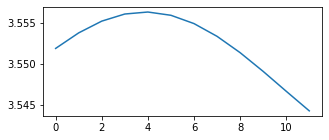

Successfully stored load data!!
57 DIYARBAKIR_Cungus


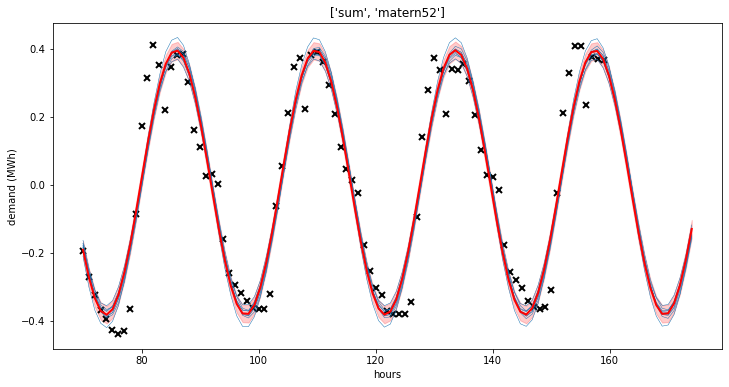

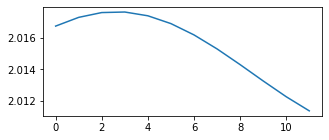

Successfully stored load data!!


In [305]:
if __name__ == '__main__':
    T0, T = 70, 160
    Tdiff = T-T0
    
    # kernel
    kernel = gpflow.kernels.Cosine(lengthscales=[20.3], variance=1.4)
    #kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Cosine(lengthscales=[70.9], variance=1.4)])
    kernel = gpflow.kernels.Product([kernel, gpflow.kernels.RBF(lengthscales=[45.9], variance=9.9)]) # cos len 0.16 / 0.26, RBF var 6/0.9
    #kernel = gpflow.kernels.Product([gpflow.kernels.Cosine(), gpflow.kernels.RBF()]) # cos len 0.16 / 0.26, RBF var 6/0.9
    #kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Linear(variance=0.12)])
    #kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Cosine(lengthscales=[0.33])])
    kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])
    kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Matern52(variance=7.2, lengthscales=[100.3])])

    run_gpr(nodes_special2, kernel, 1.5, T0, T, added_loads, OPT=True, PLOT=True, PLOT_LARGE=False, PLOT_MEAN=True)

#### All the rest

0 KIRKLARELI_Luleburgaz


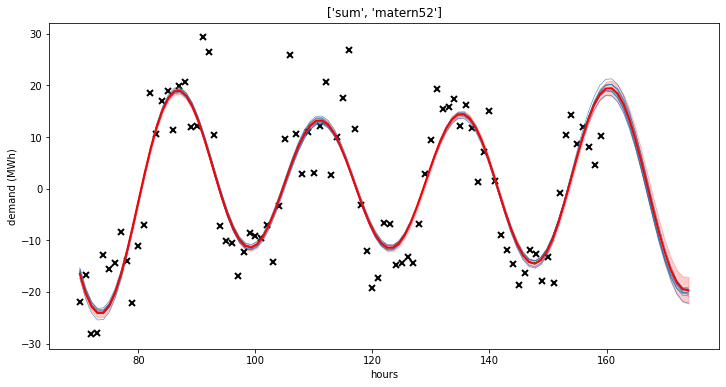

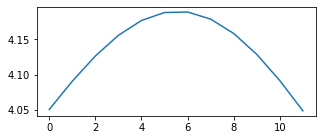

Successfully stored load data!!
1 ISTANBUL_Sultangazi


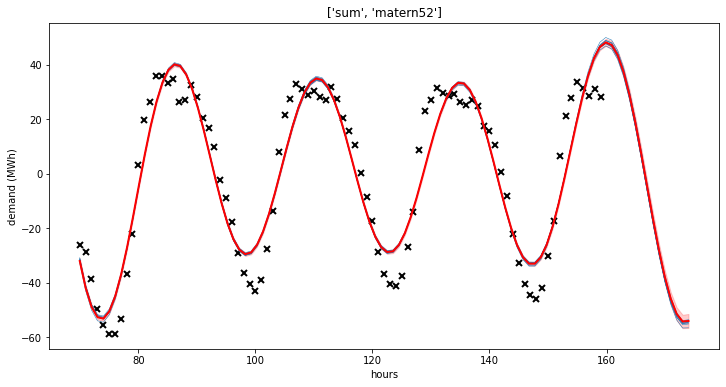

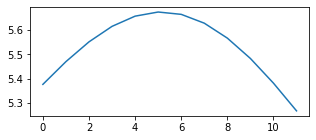

Successfully stored load data!!
3 ISTANBUL_Eyup


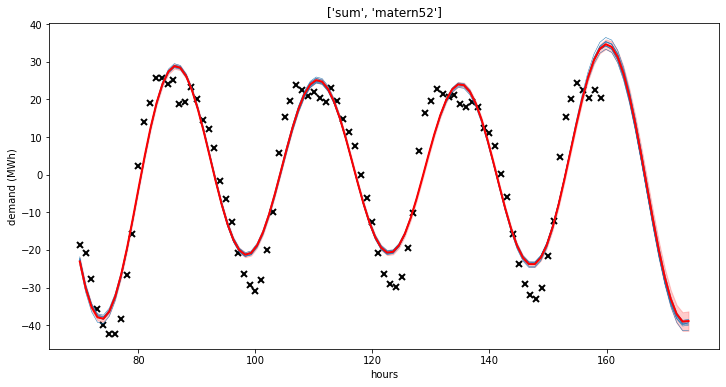

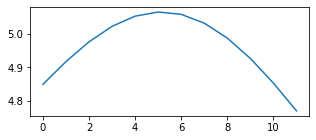

Successfully stored load data!!
4 ISTANBUL_Sancaktepe


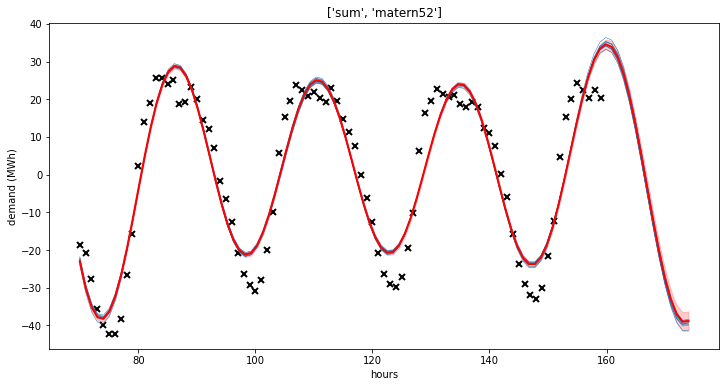

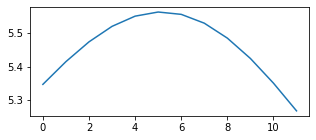

Successfully stored load data!!
5 ISTANBUL_Umraniye


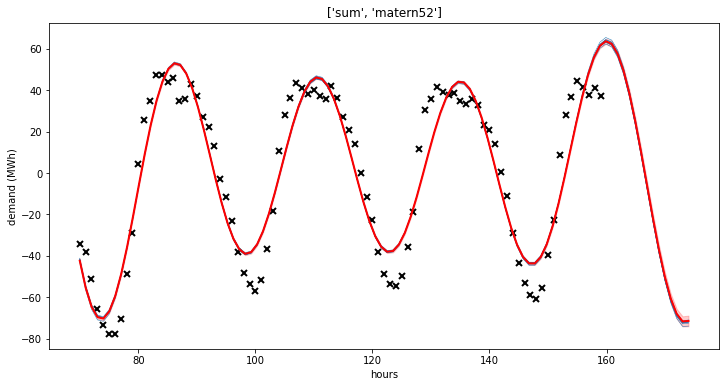

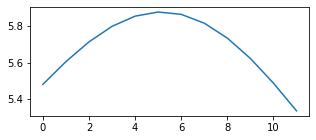

Successfully stored load data!!
6 KOCAELI_Gebze


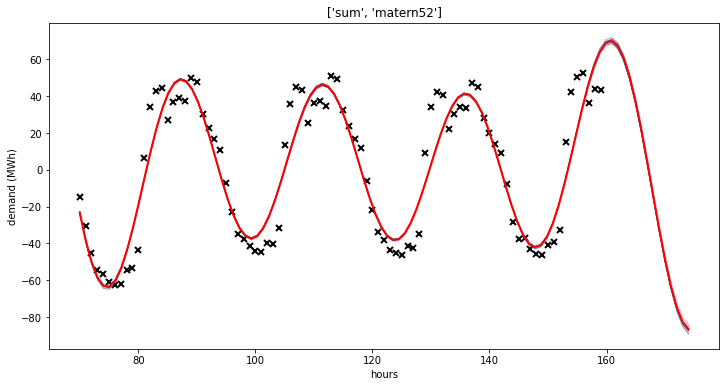

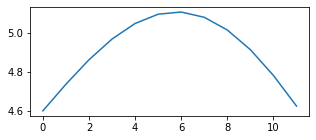

Successfully stored load data!!
7 CANAKKALE_Biga


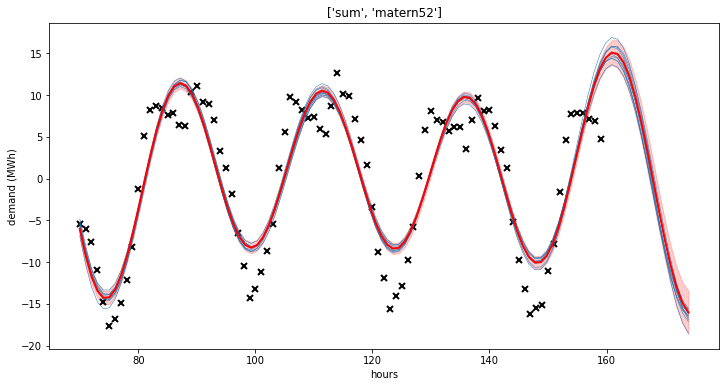

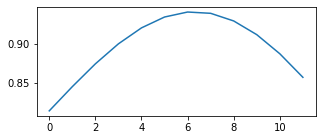

Successfully stored load data!!
8 BALIKESIR_Altieylul


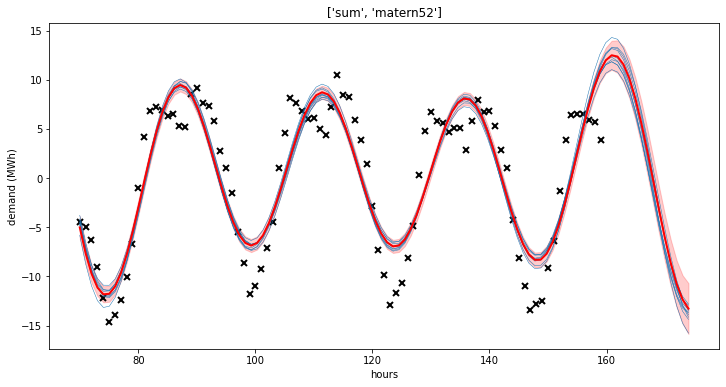

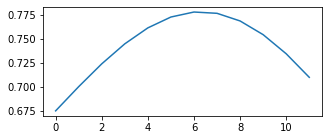

Successfully stored load data!!
9 IZMIR_Aliaga


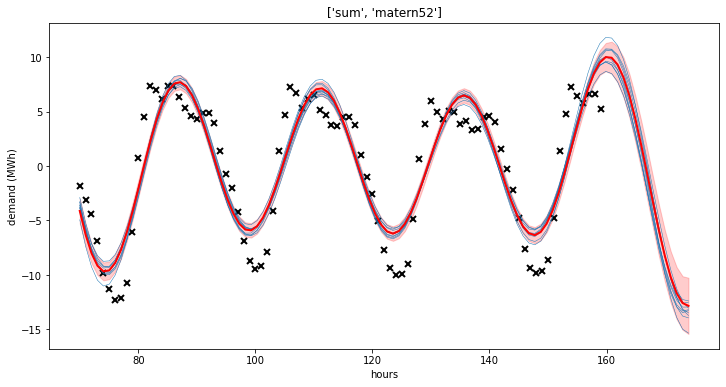

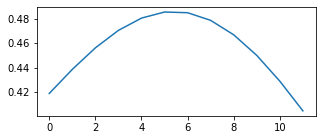

Successfully stored load data!!
10 IZMIR_Karabaglar


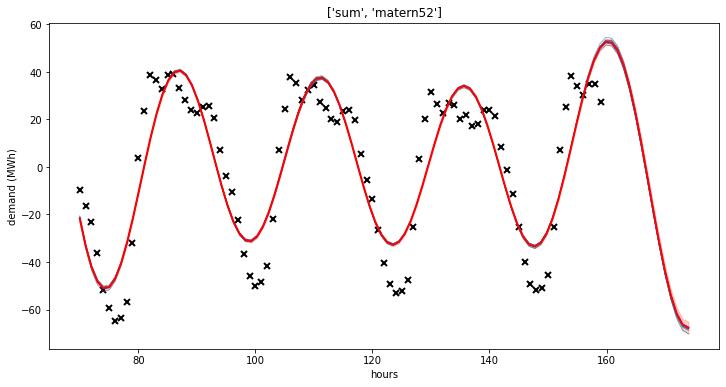

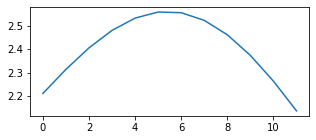

Successfully stored load data!!
11 ANTALYA_Kepez


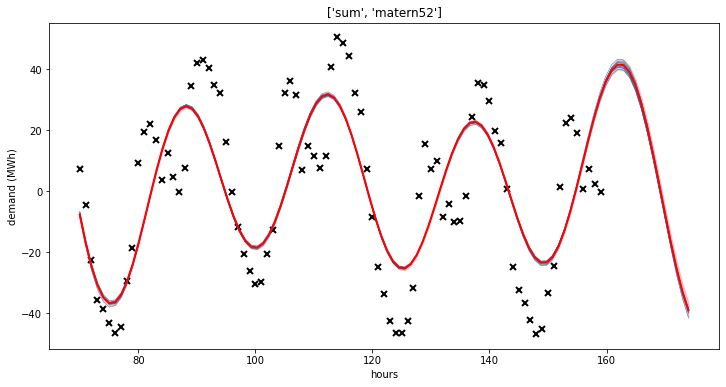

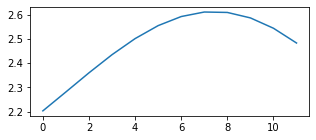

Successfully stored load data!!
12 ADANA_Ceyhan


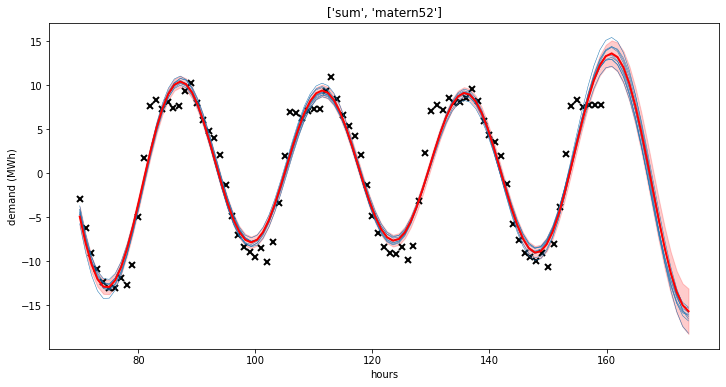

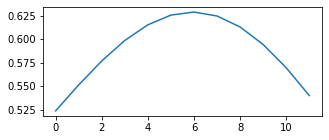

Successfully stored load data!!
15 KONYA_Selcuklu


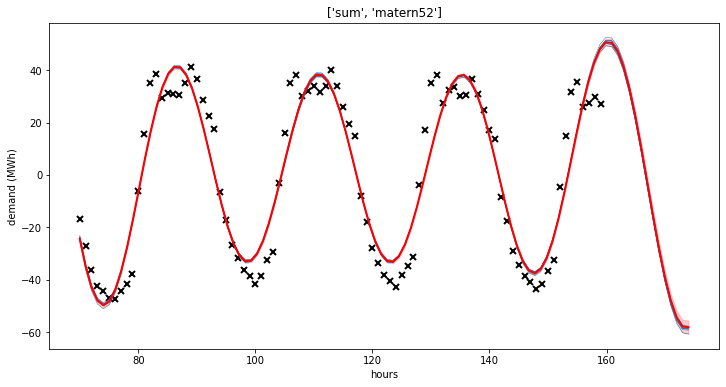

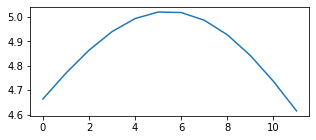

Successfully stored load data!!
18 KAYSERI_Melikgazi


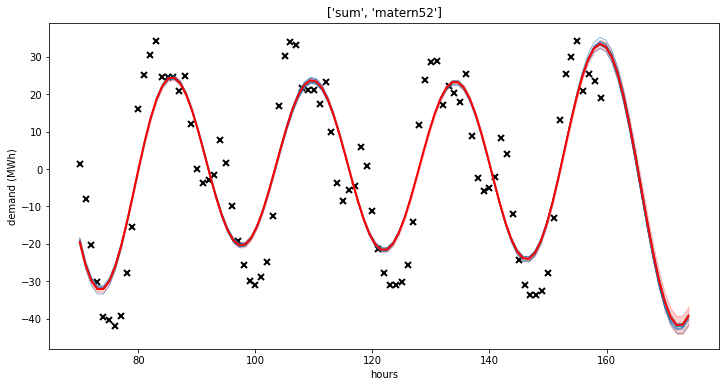

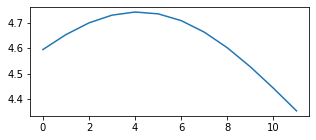

Successfully stored load data!!
21 ZONGULDAK_Eregli


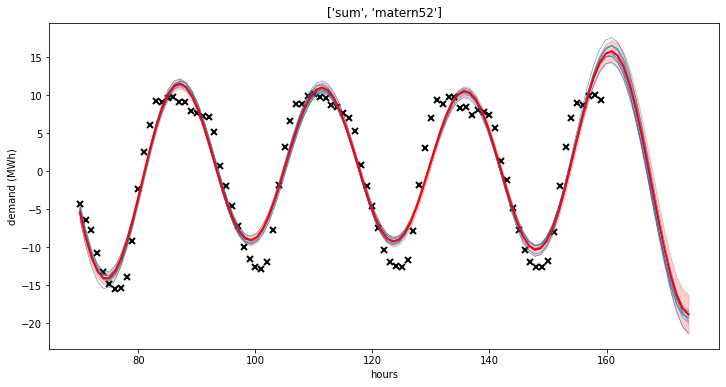

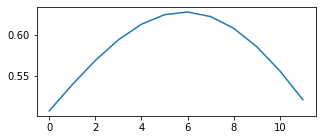

Successfully stored load data!!
22 SAMSUN_Carsamba


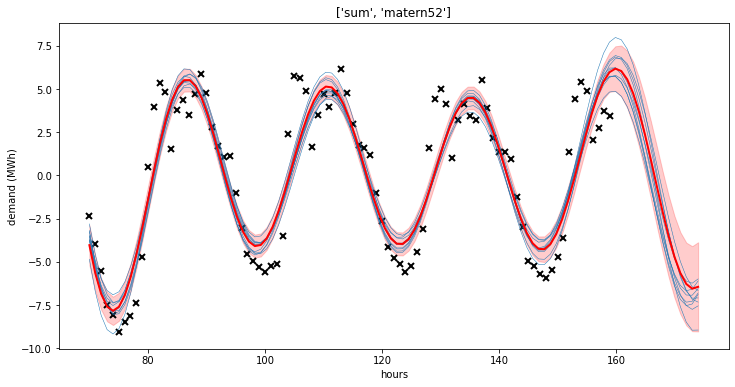

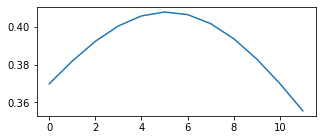

Successfully stored load data!!
24 AMASYA_Merkez


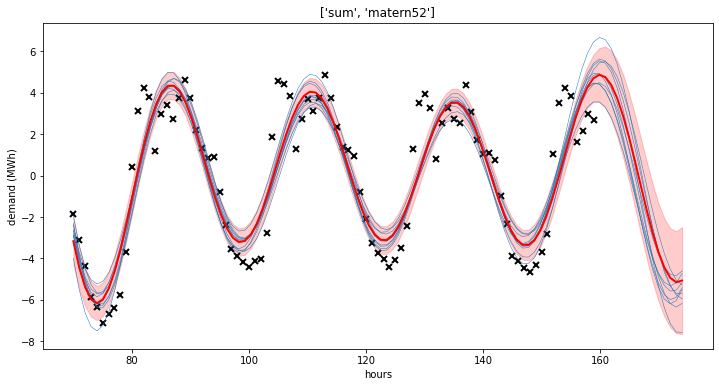

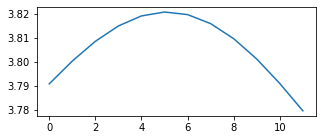

Successfully stored load data!!
25 SIVAS_Merkez


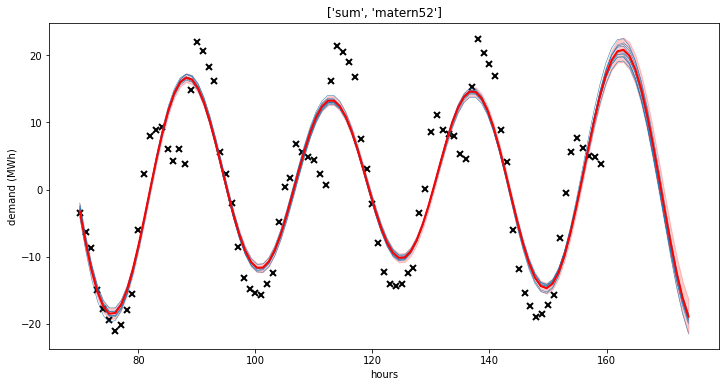

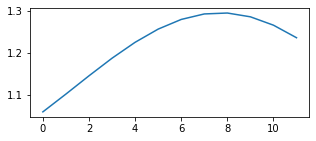

Successfully stored load data!!
29 DIYARBAKIR_Kayapinar


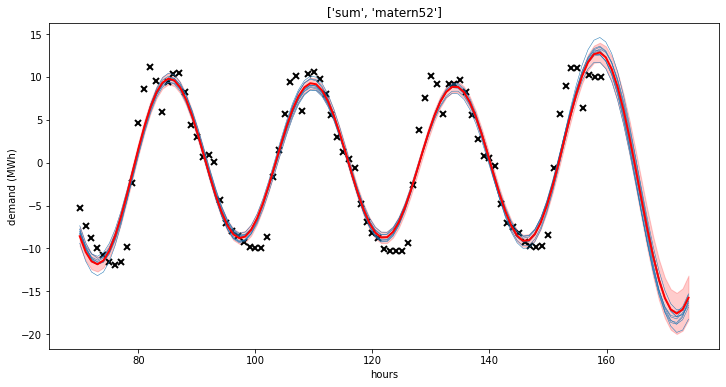

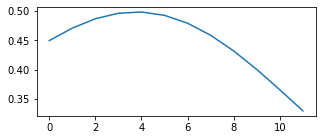

Successfully stored load data!!
30 BATMAN_Merkez


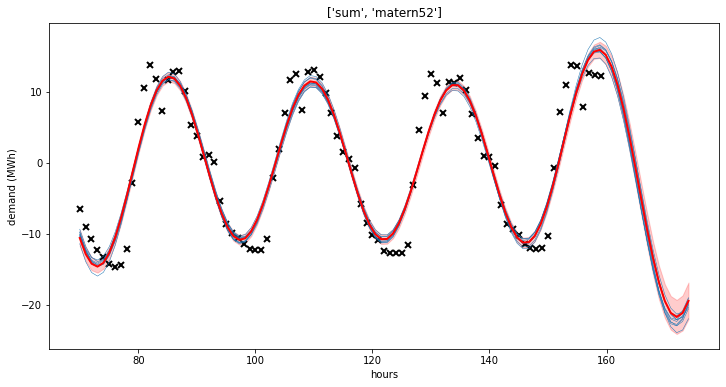

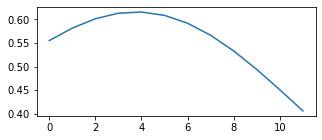

Successfully stored load data!!
31 SANLIURFA_Eyyubiye


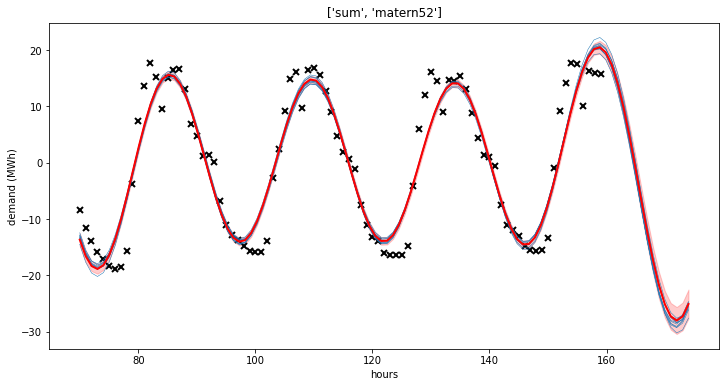

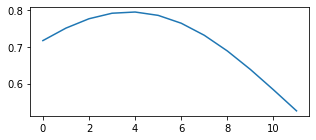

Successfully stored load data!!
33 DENIZLI_Pamukkale


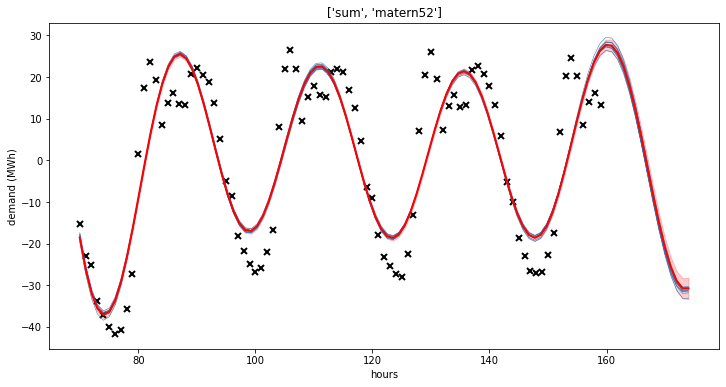

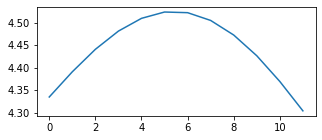

Successfully stored load data!!
34 KONYA_Seydisehir


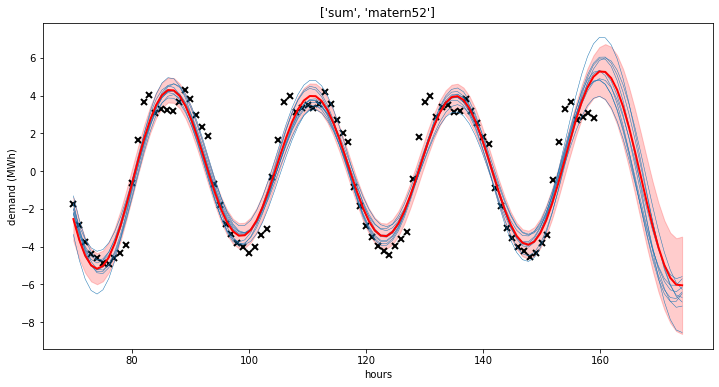

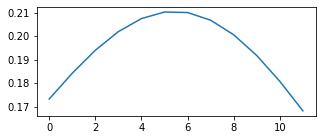

Successfully stored load data!!
35 ANKARA_Nallihan


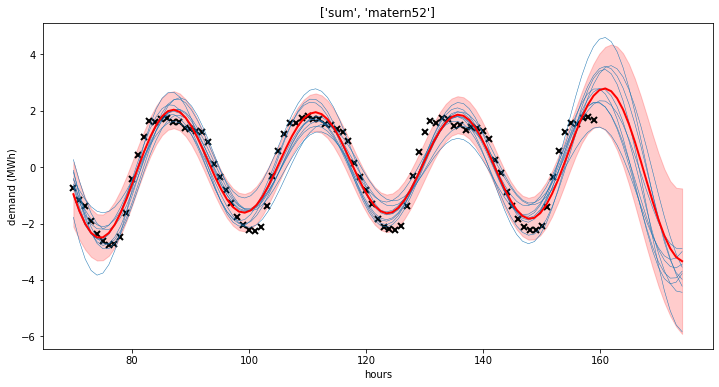

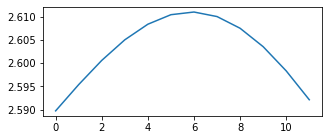

Successfully stored load data!!
36 SAMSUN_Bafra


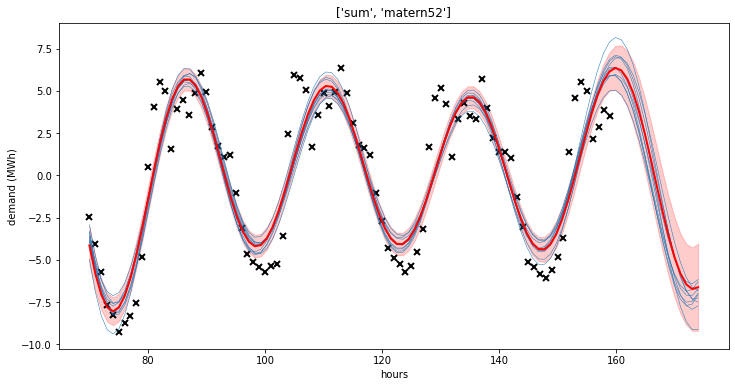

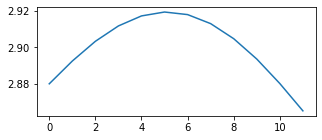

Successfully stored load data!!
37 TEKIRDAG_Marmaraereglisi


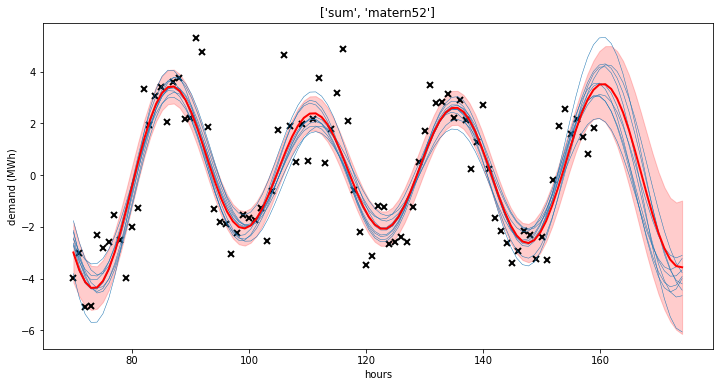

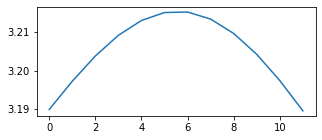

Successfully stored load data!!
38 ISTANBUL_Avcilar


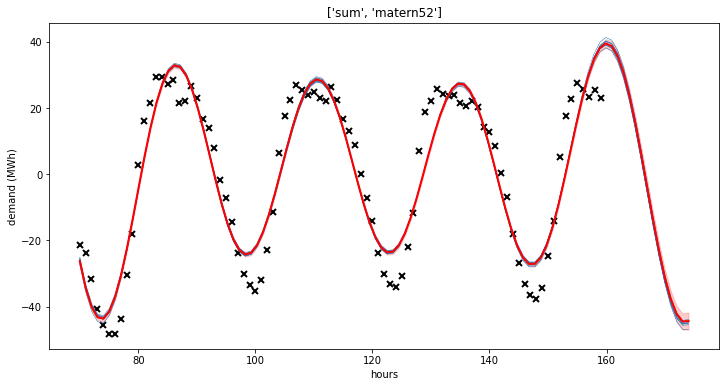

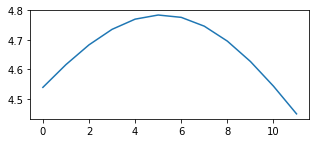

Successfully stored load data!!
39 BURSA_Nilufer


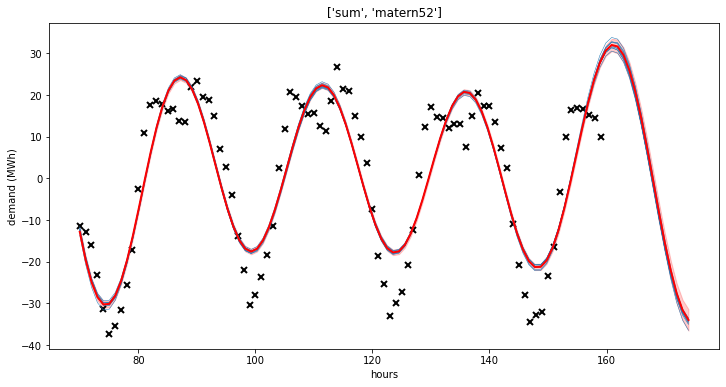

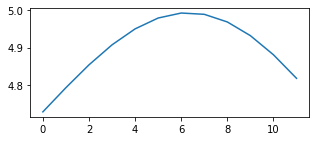

Successfully stored load data!!
41 KUTAHYA_Tavsanli


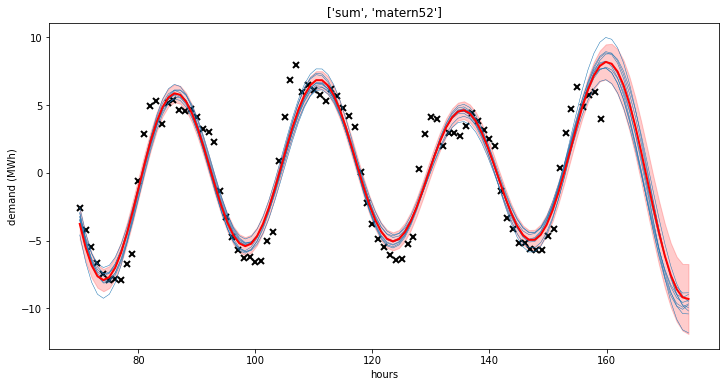

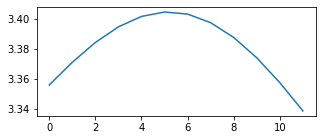

Successfully stored load data!!
42 MANISA_Soma


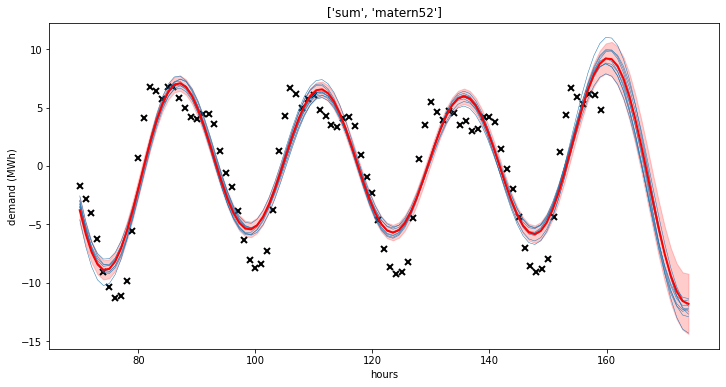

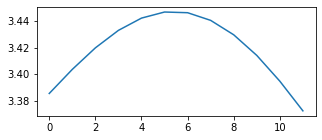

Successfully stored load data!!
43 IZMIR_Kemalpasa


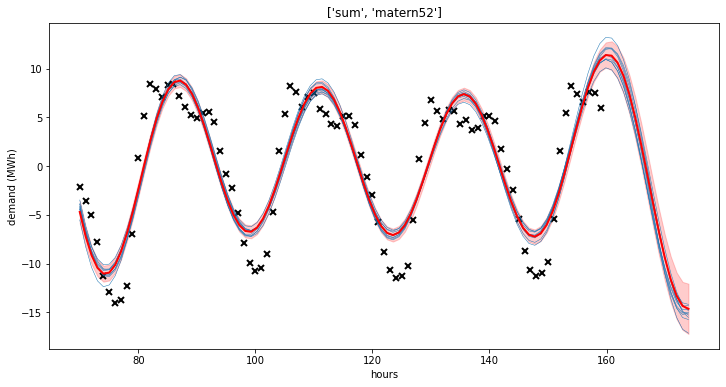

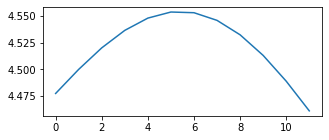

Successfully stored load data!!
44 IZMIR_Bornova


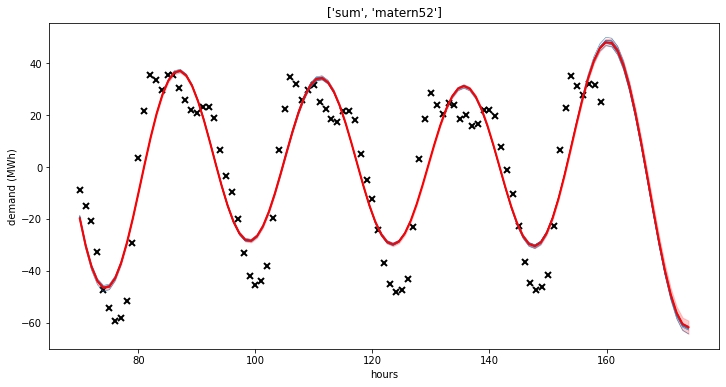

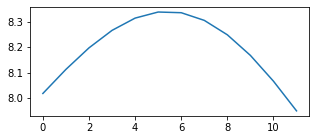

Successfully stored load data!!
45 MUGLA_Yatagan


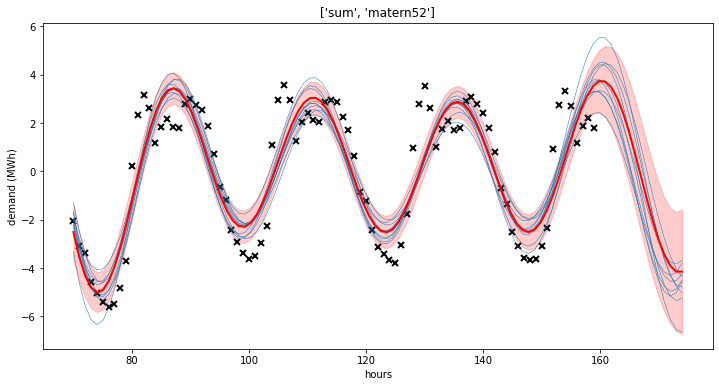

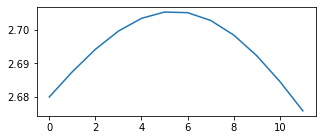

Successfully stored load data!!
46 AYDIN_Germencik


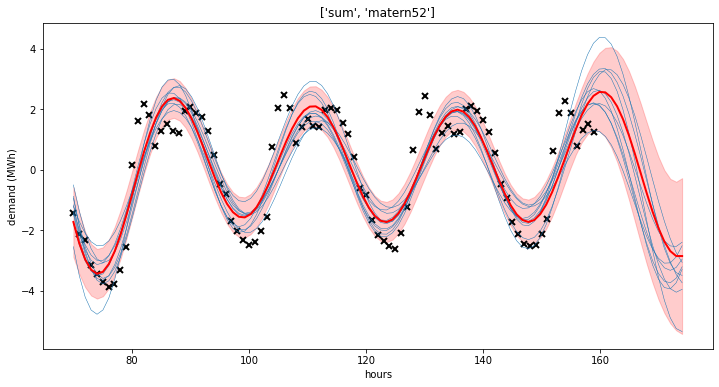

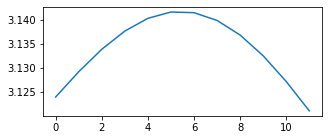

Successfully stored load data!!
47 MUGLA_Milas


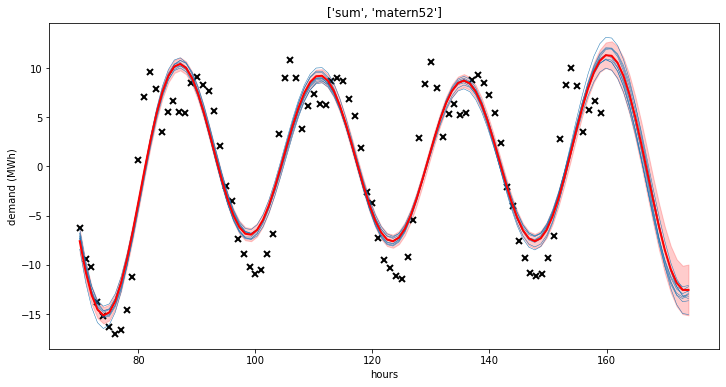

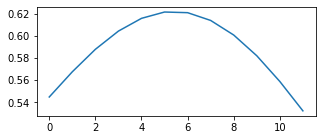

Successfully stored load data!!
48 ANTALYA_Manavgat


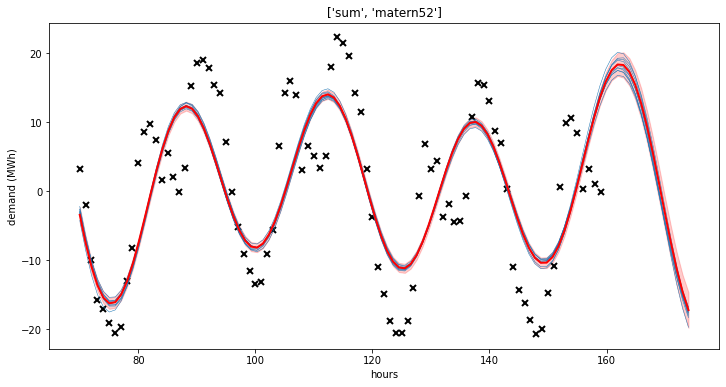

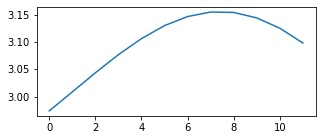

Successfully stored load data!!
52 SAKARYA_Adapazari


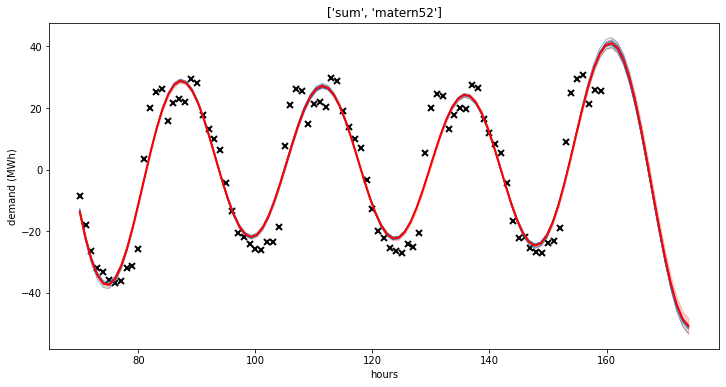

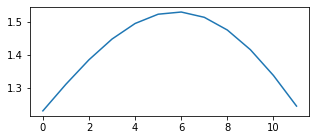

Successfully stored load data!!
53 KOCAELI_Izmit


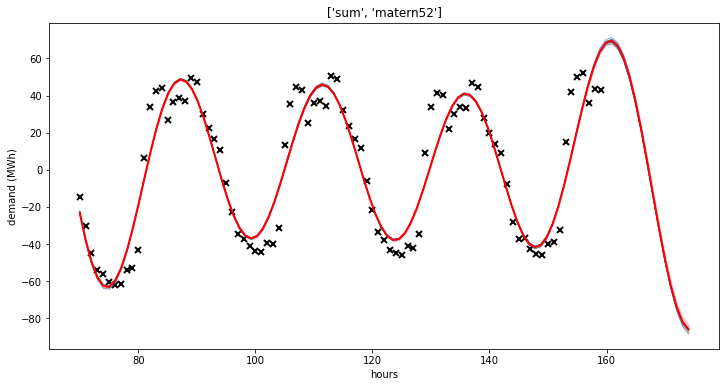

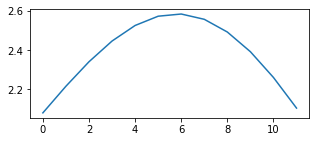

Successfully stored load data!!
54 DUZCE_Merkez


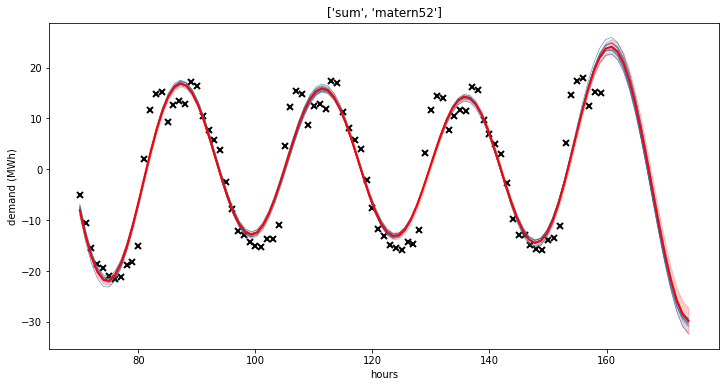

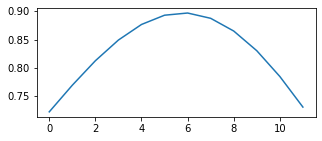

Successfully stored load data!!
55 SANLIURFA_Birecik


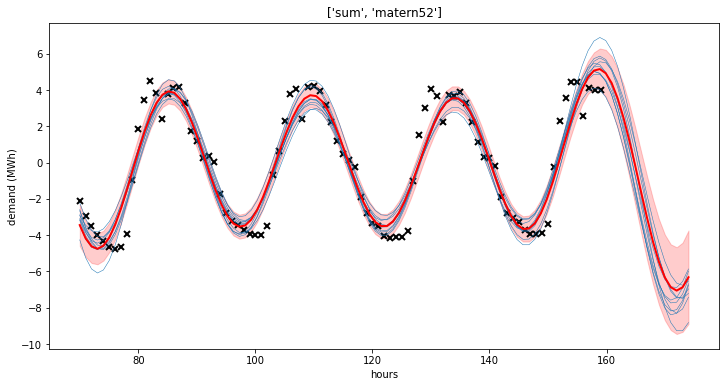

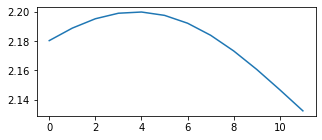

Successfully stored load data!!
56 SANLIURFA_Bozova


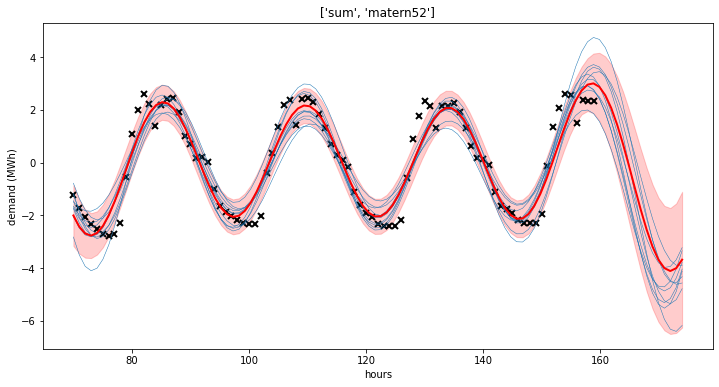

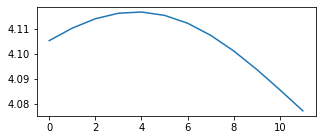

Successfully stored load data!!
58 KAHRAMANMARAS_Elbistan


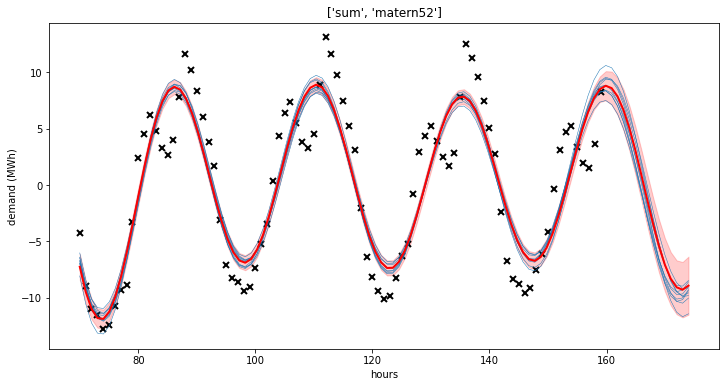

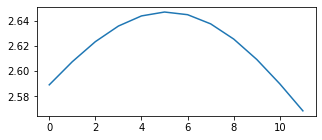

Successfully stored load data!!
59 SAMSUN_Terme


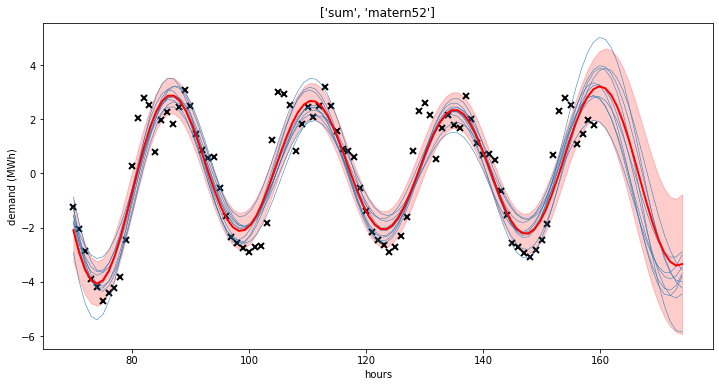

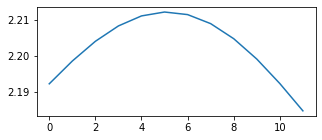

Successfully stored load data!!


In [306]:
if __name__ == '__main__':
    T0, T = 70, 160 # 0, 153
    Tdiff = T-T0
    
    kernel = gpflow.kernels.Cosine(lengthscales=[32.3], variance=21.4)
    #kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Cosine(lengthscales=[70.9], variance=1.4)])
    kernel = gpflow.kernels.Product([kernel, gpflow.kernels.RBF(lengthscales=[45.9], variance=9.9)]) # cos len 0.16 / 0.26, RBF var 6/0.9
    #kernel = gpflow.kernels.Product([gpflow.kernels.Cosine(), gpflow.kernels.RBF()]) # cos len 0.16 / 0.26, RBF var 6/0.9
    #kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Linear(variance=0.12)])
    #kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Cosine(lengthscales=[0.33])])
    kernel = gpflow.kernels.Sum([kernel, gpflow.kernels.Constant()])
    kernel = gpflow.kernels.Product([kernel, gpflow.kernels.Matern52(variance=0.11, lengthscales=[200.3])])

    # sample, increase loads, scale, fit, Cholesky, small, rescale mean
    nodes = list(range(len(nodes_network)))
    for node in nodes_special:
        nodes.remove(node)
        
    run_gpr(nodes_rest, kernel, 1.5, T0, T, added_loads, OPT=False, PLOT=True, PLOT_LARGE=False, PLOT_MEAN=True)

### Saved Konfigurations

## Existing LoadData file

Mean dim:  (12, 1)
Cov dim:  (12, 12)


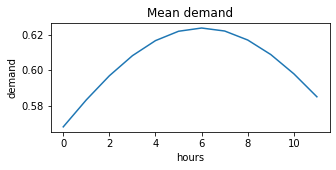

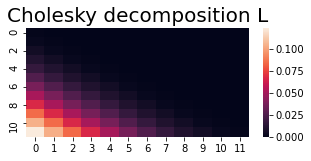

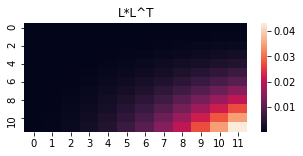

In [189]:
# hide

for i in [58]:#range(len(nodes_network)):
    # load DCsOPF case39 LoadData file
    mat = scipy.io.loadmat(str('data/covariance_matrices/LoadData_new_'+str(i)+'.mat'))
    mat_mean = scipy.io.loadmat(str('data/covariance_matrices/LoadData_new_rescaled_'+str(i)+'.mat'))

    means = DF(mat_mean['mu_post'])
    cov = DF(mat['Lpost'])
    print('Mean dim: ', means.shape)
    print('Cov dim: ', cov.shape)

    cov_mat_ = cov.dot(np.transpose(cov))
    
    plt.plot(means.index, means[0])
    plt.title('Mean demand')
    plt.xlabel('hours')
    plt.ylabel('demand')
    plt.show()

    ax = sns.heatmap(cov)
    plt.title('Cholesky decomposition L', fontsize=20)
    plt.show()

    sns.heatmap(cov_mat_)
    plt.title('L*L^T')
    plt.show()

Mean dim:  (200, 1)
Cov dim:  (200, 200)
         0         1         2         3         4         5         6    \
0   0.002167  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.004389  0.000500  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.007312  0.001502  0.000169  0.000000  0.000000  0.000000  0.000000   
3   0.010846  0.003092  0.000643  0.000087  0.000000  0.000000  0.000000   
4   0.014840  0.005286  0.001571  0.000315  0.000085  0.000000  0.000000   
5   0.019100  0.008022  0.003067  0.000779  0.000317  0.000078  0.000000   
6   0.023417  0.011167  0.005190  0.001563  0.000802  0.000276  0.000072   
7   0.027587  0.014540  0.007922  0.002730  0.001637  0.000686  0.000257   
8   0.031431  0.017943  0.011170  0.004304  0.002895  0.001387  0.000643   
9   0.034803  0.021182  0.014774  0.006264  0.004611  0.002445  0.001317   
10  0.037599  0.024100  0.018532  0.008540  0.006765  0.003892  0.002350   
11  0.039754  0.026587  0.022227  0.011024  0.0

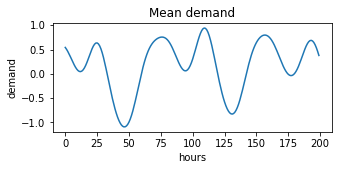

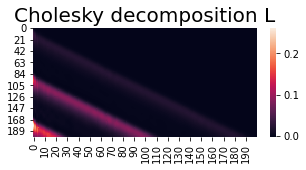

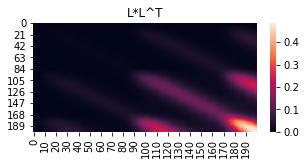

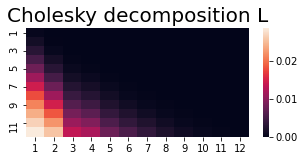

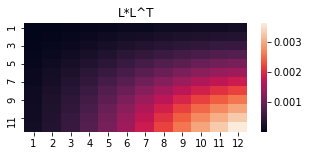

In [191]:
# hide

# load DCsOPF case39 LoadData file
mat = scipy.io.loadmat('data/LoadData.mat')
#mat = scipy.io.loadmat('data/covariance_matrices/LoadData_new_20.mat')

means = DF(mat['mu_post'])
cov = DF(mat['Lpost'])
print('Mean dim: ', means.shape)
print('Cov dim: ', cov.shape)

cov_mat_ = cov.dot(np.transpose(cov))

print(cov[0:12])

plt.plot(means.index, means[0])
plt.title('Mean demand')
plt.xlabel('hours')
plt.ylabel('demand')
plt.show()

ax = sns.heatmap(cov)
plt.title('Cholesky decomposition L', fontsize=20)
plt.show()

sns.heatmap(cov_mat_)
plt.title('L*L^T')
plt.show()

ax = sns.heatmap(cov.loc[1:12,1:12])
plt.title('Cholesky decomposition L', fontsize=20)
plt.show()

sns.heatmap(cov_mat_.loc[1:12,1:12])
plt.title('L*L^T')
plt.show()

# Test Data

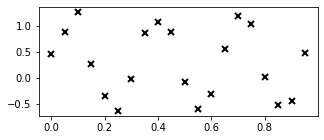

In [174]:
N = 20

data = np.genfromtxt("regression_1D.csv", delimiter=",")
X = data[:, 0].reshape(-1, 1)
Y = data[:, 1].reshape(-1, 1)

X = np.array([[a] for a in np.array(range(N))], dtype=np.float64)
Y = np.sin(X) + [[a/2] for a in np.random.rand(N)]
X = X / 20

_ = plt.plot(X, Y, "kx", mew=2)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     1   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     0.3 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │     0.1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

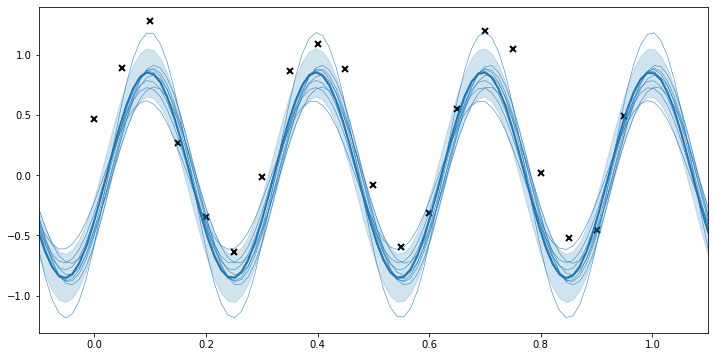

In [178]:
kernel = gpflow.kernels.Cosine()
m = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
m.likelihood.variance.assign(0.1)
m.kernel.lengthscales.assign(0.3)
#opt = gpflow.optimizers.Scipy()
#opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
print_summary(m)
## generate test points for prediction
xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1) 
mean, var = m.predict_f(xx)
_, cov_full2 = m.predict_f(xx, full_cov=True)
cov2 = cov_full2.numpy()[0,:,:]
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
_ = plt.xlim(-0.1, 1.1)

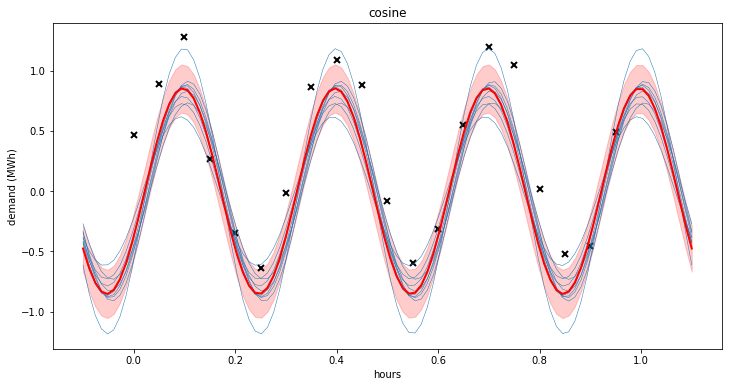

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     1   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     0.3 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │     0.1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

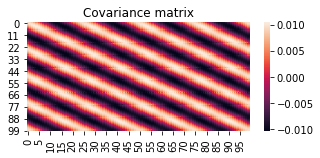

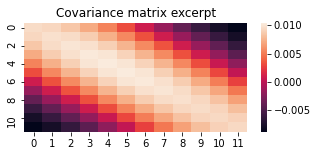

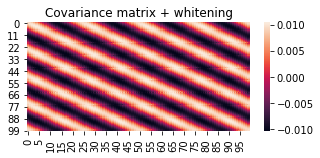

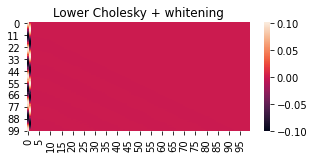

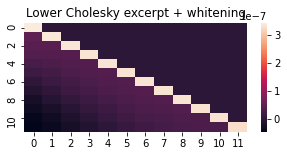

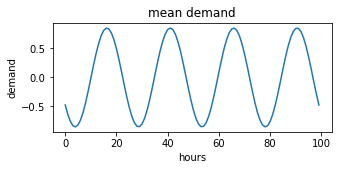

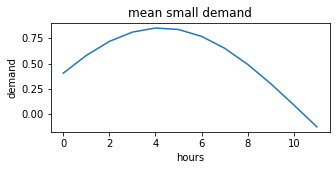

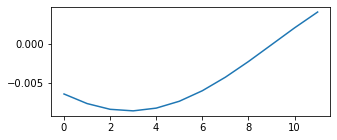

Successfully stored load data!!


In [179]:
L = None # lower triangluar matrix
whitening = 1e-13
cov_ = cov2 + whitening*np.eye(len(cov2))
L = scipy.linalg.cholesky(cov_, lower=True)

if L is not None:
    a, b = 1, 12
    mean_small = mean[a:a+b]
    L_small = L[a:a+b,a:a+b]

    if True:
        GPFLOW_plot_it(X, Y, xx, m, mean, var, cov, samples, whitening, 12)
    elif PLOT: 
        GPFLOW_plot_it_small(X, Y, xx, m, mean, var, cov, samples, whitening, 12)

    # rescale and save in new file
   # mean_rescaled = ((scaler_demand.inverse_transform(mean_small)) * 0.01) # durch 100 teilen
    mean_rescaled = (mean_small) * 0.01
    L_rescaled = L_small

    #print(mean_rescaled)

    plt.plot(mean_rescaled)
    plt.show()

    to_mat(L_rescaled, mean_rescaled, str('LoadData_test_'))

In [181]:
cov2[1:12,1:12]

array([[ 0.00991752,  0.00972304,  0.00890528,  0.00751668,  0.00564623,
         0.00341385,  0.00096263, -0.0015503 , -0.00396385, -0.0061233 ,
        -0.00789024],
       [ 0.00972304,  0.01015737,  0.00994058,  0.00908658,  0.00765011,
         0.00572324,  0.0034295 ,  0.00091592, -0.00165637, -0.00412249,
        -0.00632434],
       [ 0.00890528,  0.00994058,  0.01033867,  0.01007401,  0.00916359,
         0.00766576,  0.00567653,  0.00332343,  0.00075728, -0.00185741,
        -0.00435304],
       [ 0.00751668,  0.00908658,  0.01007401,  0.01041568,  0.01008967,
         0.00911688,  0.00755969,  0.00551789,  0.00312238,  0.00052673,
        -0.0021027 ],
       [ 0.00564623,  0.00765011,  0.00916359,  0.01008967,  0.01036897,
         0.00998359,  0.00895824,  0.00735864,  0.00528734,  0.0028771 ,
         0.00028243],
       [ 0.00341385,  0.00572324,  0.00766576,  0.00911688,  0.00998359,
         0.01021033,  0.00978255,  0.00872769,  0.00711336,  0.00504305,
         0.002

In [185]:
cov

0         1         2         3         4         5         6   \
0   0.001167  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.002871  0.001166  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.005954  0.002868  0.001165  0.000000  0.000000  0.000000  0.000000   
3   0.010706  0.005947  0.002865  0.001165  0.000000  0.000000  0.000000   
4   0.017467  0.010689  0.005938  0.002861  0.001164  0.000000  0.000000   
5   0.026506  0.017435  0.010669  0.005927  0.002857  0.001163  0.000000   
6   0.037972  0.026448  0.017396  0.010646  0.005917  0.002853  0.001162   
7   0.051859  0.037877  0.026380  0.017352  0.010623  0.005905  0.002849   
8   0.067967  0.051711  0.037764  0.026304  0.017307  0.010599  0.005895   
9   0.085880  0.067747  0.051537  0.037642  0.026225  0.017261  0.010575   
10  0.104953  0.085568  0.067492  0.051348  0.037514  0.026145  0.017216   
11  0.124312  0.104526  0.085209  0.067216  0.051153  0.037385  0.026067   

          7         8         9         10        11  
0   0.000000  0.000000  0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  0.000000  0.000000  
3   0.000000  0.000000  0.000000  0.000000  0.000000  
4   0.000000  0.000000  0.000000  0.000000  0.000000  
5   0.000000  0.000000  0.000000  0.000000  0.000000  
6   0.000000  0.000000  0.000000  0.000000  0.000000  
7   0.001161  0.000000  0.000000  0.000000  0.000000  
8   0.002845  0.001160  0.000000  0.000000  0.000000  
9   0.005884  0.002841  0.001159  0.000000  0.000000  
10  0.010552  0.005874  0.002838  0.001158  0.000000  
11  0.017173  0.010531  0.005865  0.002835  0.001158